# `DMKDE` performance on a `mixture`

In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [2]:
from IPython import display
display.Image("https://miro.medium.com/max/900/1*yyazQ3QnW-gj__noFczZMA.png")

<IPython.core.display.Image object>

## About the libraries we need

Install `qmc`

Let´s install (git clone to the file system of the Colab VM) the module `qmc` which contains
> Custom models inherited from the super class `tf.keras.Model`.

> Custom layers inherited from the super class `tf.keras.layers.Layer`.

More information on customization when using `tf` this can be found at [here](https://www.tensorflow.org/tutorials/customization/custom_layers#models_composing_layers).

In [3]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R qmc qmc1
    !git clone https://github.com/fagonzalezo/qmc.git
    !mv qmc qmc1
    !mv qmc1/qmc .
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'qmc': No such file or directory
rm: cannot remove 'qmc1': No such file or directory
Cloning into 'qmc'...
remote: Enumerating objects: 516, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 516 (delta 46), reused 37 (delta 37), pack-reused 439
Receiving objects: 100% (516/516), 37.05 MiB | 16.54 MiB/s, done.
Resolving deltas: 100% (235/235), done.


Install `KDEpy`

In [4]:
pip install KDEpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 420 kB 5.6 MB/s 


Install `fastKDE`

In [5]:
pip install fastkde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 952 kB 8.5 MB/s 


General ones that include:

- `pandas` : For managing dataframes that come from txt files.
- `numpy` : For managing multidimensional arrays.
- `pylab` : For plotting purposes.

In [6]:
import pandas as pd
import numpy as np
import pylab as pl
from typeguard import typechecked
import tensorflow_probability as tfp
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
import tensorflow as tf
import tensorflow_probability as tfp
import qmc.tf.layers as layers
import qmc.tf.models as models
from scipy.stats import norm, bernoulli, gaussian_kde
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from KDEpy import NaiveKDE
from KDEpy import TreeKDE
from KDEpy import FFTKDE
from fastkde import fastKDE
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import seaborn as sns

 Clone repo for sampling made with Pytorch

In [7]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R nf
    !git clone https://github.com/VishakhG/normalizing-flows nf
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'nf': No such file or directory
Cloning into 'nf'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 49 (delta 12), reused 48 (delta 11), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [8]:
import nf.src.densities as densitiesnf
import nf.src.normalizing_flows as nfs
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable

In [9]:
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

## Auxiliary functions

Plot density function

In [ ]:
def plot_dens_func(dens_func, ax=None):
    if ax is None:
        _, ax = plt.subplots(1)
    x = np.linspace(-6, 6, int(1e2))
    y = np.linspace(-6, 6, int(1e2))
    xx, yy = np.meshgrid(x, y)
    in_tens = tf.constant(np.vstack([xx.ravel(), yy.ravel()]).T,dtype=tf.float32)
    z = dens_func(in_tens).numpy().reshape(xx.shape)

    cmap = plt.get_cmap('inferno')
    ax.contourf(x, y, z.reshape(xx.shape), cmap=cmap)

Constant for `DMKDE` and `EIG_DMKDE` predictions

In [ ]:
def calculate_constant_qmkde(gamma=1, dimension = 1):
  sigma = (4*gamma)**(-1/2)
  coefficient = 1 /  (2*np.pi*sigma**2)**(dimension/2)
  return coefficient

Define `raw_kde` method 

In [ ]:
def raw_kde(x_test, x_train, gamma = 1):
  sigma = (2*gamma)**(-1/2)
  euclidean_distance = np.sum(((x_test-x_train))**2, axis=1)
  exponential  = np.exp(-euclidean_distance/(2*sigma**2))
  coefficient = 1 /  (2*np.pi*sigma**2)**(x_train.shape[1]/2) 
  constant_outside = 1/(x_train.shape[0]) * coefficient
  result = constant_outside * np.sum(exponential)  
  return result

## Data

Mixture of two gaussian components generated using `tensorflow_probability`
***

Sample size 

In [ ]:
sample_size = 1000000

Create the mixture model

In [ ]:
first_normal = tfp.distributions.MultivariateNormalDiag(
    loc=[1., -1],
    scale_diag=[1, 2.])

second_normal = tfp.distributions.MultivariateNormalDiag(
    loc=[-2., 2],
    scale_diag=[2, 1.])

bimix_gauss = tfp.distributions.Mixture(
  cat = tfp.distributions.Categorical(probs=[0.5, 0.5]),
  components=[first_normal,second_normal])

In [ ]:
def density_mixt(nparray):
  return bimix_gauss.prob(nparray)

Generate the sample - Do not run

In [ ]:
X = bimix_gauss.sample(sample_size)

In [ ]:
X = X.numpy()

Save data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#np.savetxt(fname="/content/drive/MyDrive/UniversidadNacional/Thesis/Datasets/MIXT/mixt_1M.csv", delimiter=" ", X = X)

Load data

In [ ]:
X = np.loadtxt("/content/drive/MyDrive/UniversidadNacional/Thesis/Datasets/MIXT/mixt_1M.csv")

In [ ]:
X.shape

(1000000, 2)

Plot of theoretical mixture vs. Samples

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


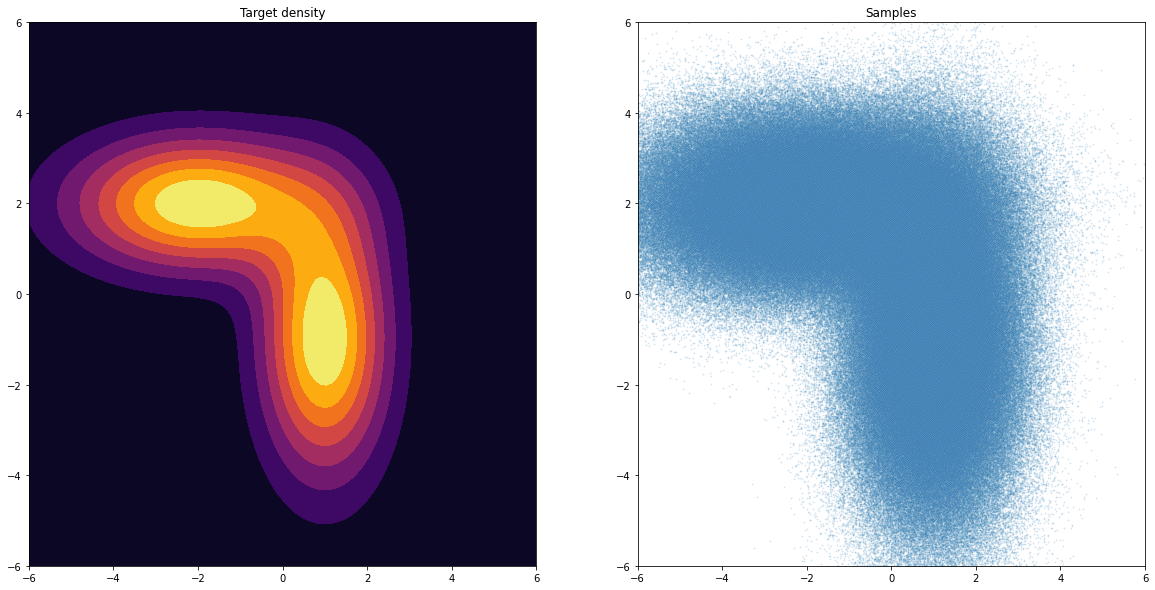

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_dens_func(density_mixt, ax = axes[0]) 
axes[0].set_title('Target density')
axes[1].set_xlim([-6,6])
axes[1].set_ylim([-6,6])
sns.scatterplot(X[:, 0], X[:, 1], alpha=.2, s = 3 ,ax=axes[1])
axes[1].set_title('Samples')
plt.show()

True densities

In [ ]:
X_densities = bimix_gauss.prob(X).numpy()

In [ ]:
X.shape

(1000000, 2)

In [ ]:
X_densities.shape

(1000000,)

Scatter plot of the data

In [ ]:
plt.rcParams["figure.figsize"] = (20*0.25,15*0.25)

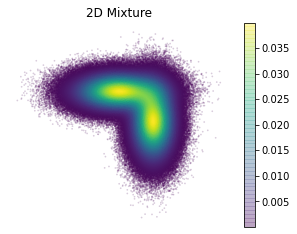

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X[:,0], X[:,1], c = X_densities , alpha = .2, s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.title('2D Mixture')
plt.yticks([])
plt.xticks([])
plt.savefig('alldensities_2Dmixt.png',dpi = 300)
plt.show()

Histogram of distances with 1000 samples - Do not run



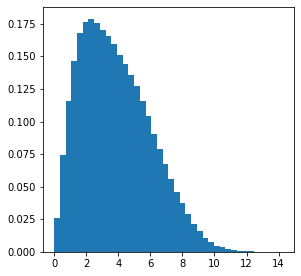

In [ ]:
distances_X = euclidean_distances(X[:1000],X[:1000])
plt.hist(distances_X[np.triu_indices_from(distances_X, k=1)].ravel(), density = True, bins=40);

We suggest a `bw = 2`.

## Experiment 1 : 10

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 10, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 2D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 2D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 2D data set shape is:(10, 2) and their densities shape is (10,)
Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)


Scatter plot of test data

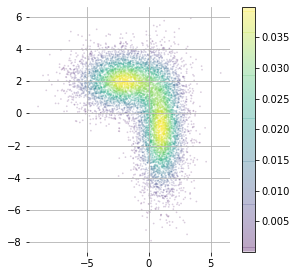

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = X_test_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.show()

### Fixing bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-10,10,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = bimix_gauss.prob(X_test_new).numpy()
    raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new])    
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Best gamma:0.25 with L1_error 0.006228394871401457


Fixed gamma

In [ ]:
gamma = 0.25

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

1.414213562373095

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test])

CPU times: user 202 ms, sys: 0 ns, total: 202 ms
Wall time: 204 ms


Scatter plot

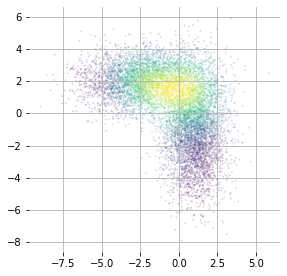

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = raw_kde_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

0.00854198895403575

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = NaiveKDE_density.evaluate(X_test)

CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 19.2 ms


Scatter plot

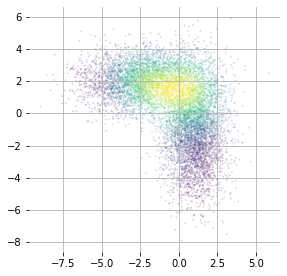

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = NaiveKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

0.008541988954035682

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = TreeKDE_density.evaluate(X_test)

CPU times: user 3.59 s, sys: 40 ms, total: 3.63 s
Wall time: 3.59 s


Scatter plot

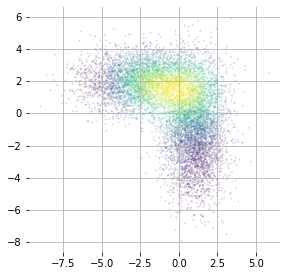

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = TreeKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

0.008549689488735128

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = np.exp(KernelDensitybt_density.score_samples(X_test))

CPU times: user 14.7 ms, sys: 14 µs, total: 14.7 ms
Wall time: 16.1 ms


Scatter plot

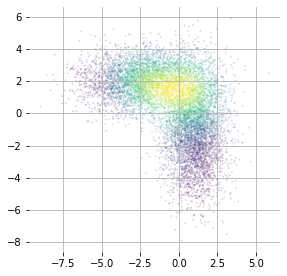

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitybt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

0.00854198895403575

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = np.exp(KernelDensitykdt_density.score_samples(X_test))

CPU times: user 11.7 ms, sys: 2.89 ms, total: 14.6 ms
Wall time: 15.4 ms


Scatter plot

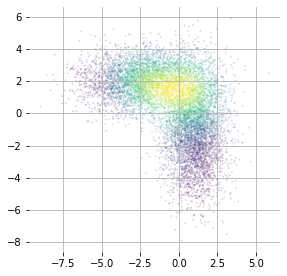

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitykdt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

0.00854198895403575

#### `fastKDE`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time fastKDE_densities = fastKDE.pdf_at_points(X_train[:,0], X_train[:,1], list_of_points = X_test)

CPU times: user 9.03 s, sys: 0 ns, total: 9.03 s
Wall time: 9.04 s


Scatter plot

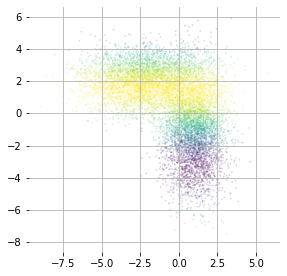

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = fastKDE_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(fastKDE_densities - X_test_densities))

0.012394261150045906

#### `DMKDE`

##### dim = 50

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

1/1 [==============================] - 1s 565ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 675 ms, sys: 31.7 ms, total: 706 ms
Wall time: 647 ms


Scatter plot 

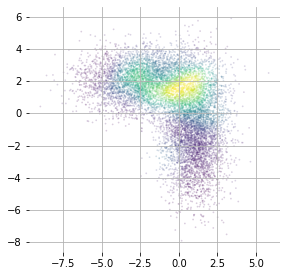

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.010022222137451173

##### dim = 100

Train

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

1/1 [==============================] - 0s 93ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1.87 s, sys: 93.3 ms, total: 1.96 s
Wall time: 1.55 s


Scatter plot 

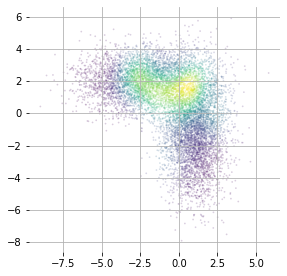

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.00971146469116211

##### dim = 500

Train

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

1/1 [==============================] - 0s 111ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1min 50s, sys: 1.72 s, total: 1min 52s
Wall time: 1min


Scatter plot 

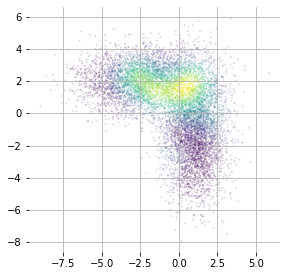

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.010014547729492188

##### dim = 1000

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

1/1 [==============================] - 0s 117ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 11min 53s, sys: 4.36 s, total: 11min 57s
Wall time: 6min 11s


Scatter plot 

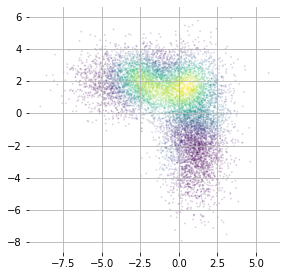

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.010230548095703125

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

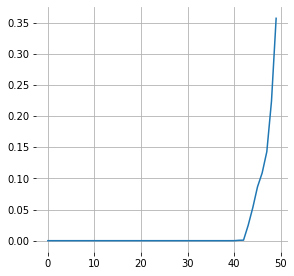

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_50.predict(X_test)

CPU times: user 531 ms, sys: 28.3 ms, total: 559 ms
Wall time: 489 ms


Scatter plot 

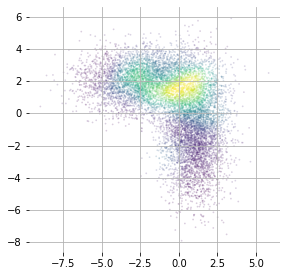

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.01002222137451172

##### dim = 100

Train

In [ ]:
num_eig = 50
dim = 100
sgd_model_100 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

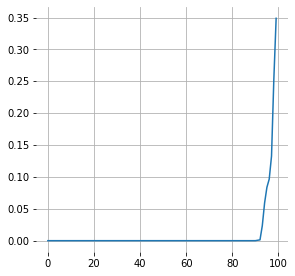

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_100.predict(X_test)

CPU times: user 397 ms, sys: 14.1 ms, total: 411 ms
Wall time: 329 ms


Scatter plot 

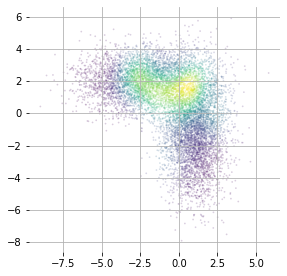

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.009711467742919923

##### dim = 500

Train

In [ ]:
num_eig = 50
dim = 500
sgd_model_500 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

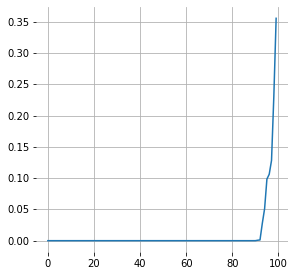

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_500.predict(X_test)

CPU times: user 492 ms, sys: 23.3 ms, total: 515 ms
Wall time: 425 ms


Scatter plot 

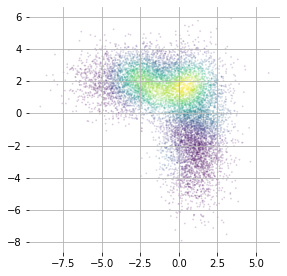

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.010014820861816407

##### dim = 1000

Train

In [ ]:
num_eig = 50
dim = 1000
sgd_model_1000 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

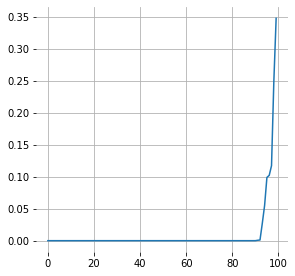

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_1000.predict(X_test)

CPU times: user 663 ms, sys: 43.5 ms, total: 706 ms
Wall time: 767 ms


Scatter plot 

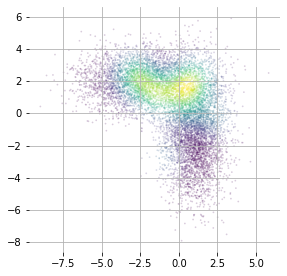

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.010233200073242188

## Experiment 2 : 100

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 100, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 2D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 2D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 2D data set shape is:(100, 2) and their densities shape is (100,)
Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)


Scatter plot of test data

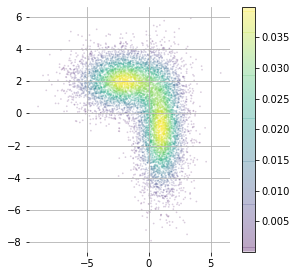

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = X_test_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.show()

### Fixing bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-10,10,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = bimix_gauss.prob(X_test_new).numpy()
    raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new])    
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Best gamma:1 with L1_error 0.004934047887373195


Fixed gamma

In [ ]:
gamma = 1

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.7071067811865475

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test])

CPU times: user 200 ms, sys: 628 µs, total: 201 ms
Wall time: 202 ms


Scatter plot

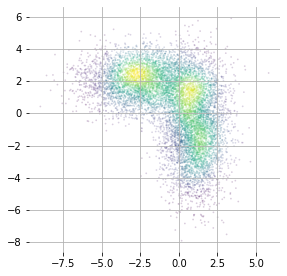

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = raw_kde_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

0.00480151918180714

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = NaiveKDE_density.evaluate(X_test)

CPU times: user 70.2 ms, sys: 197 µs, total: 70.4 ms
Wall time: 71.4 ms


Scatter plot

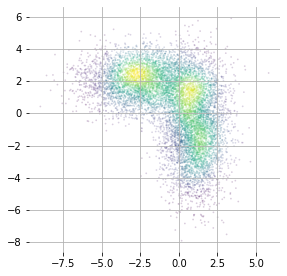

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = NaiveKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

0.004801519181807069

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = TreeKDE_density.evaluate(X_test)

CPU times: user 3.12 s, sys: 12.5 ms, total: 3.13 s
Wall time: 3.09 s


Scatter plot

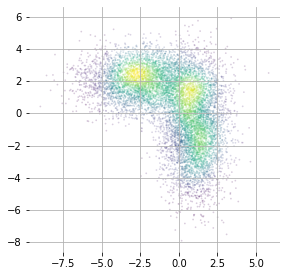

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = TreeKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

0.004808007351346663

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = np.exp(KernelDensitybt_density.score_samples(X_test))

CPU times: user 85.4 ms, sys: 0 ns, total: 85.4 ms
Wall time: 88.1 ms


Scatter plot

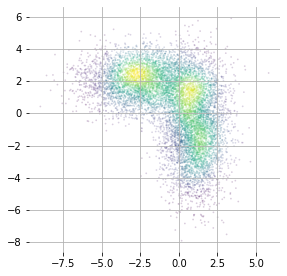

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitybt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

0.004801519181807146

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = np.exp(KernelDensitykdt_density.score_samples(X_test))

CPU times: user 84.5 ms, sys: 0 ns, total: 84.5 ms
Wall time: 85.3 ms


Scatter plot

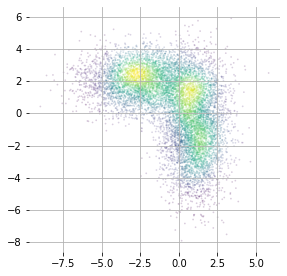

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitykdt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

0.0048015191818071455

#### `fastKDE`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time fastKDE_densities = fastKDE.pdf_at_points(X_train[:,0], X_train[:,1], list_of_points = X_test)

CPU times: user 14.7 s, sys: 2.16 ms, total: 14.7 s
Wall time: 14.6 s


Scatter plot

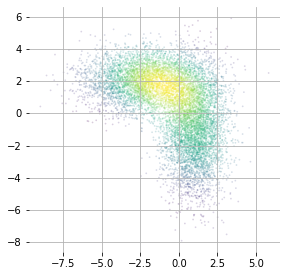

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = fastKDE_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(fastKDE_densities - X_test_densities))

0.006295257561065054

#### `DMKDE`

##### dim = 50

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

4/4 [==============================] - 3s 3ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 691 ms, sys: 55.9 ms, total: 746 ms
Wall time: 752 ms


Scatter plot 

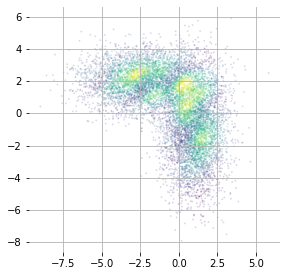

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.009953297424316407

##### dim = 100

Train

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

4/4 [==============================] - 0s 2ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1.63 s, sys: 92.5 ms, total: 1.72 s
Wall time: 1.33 s


Scatter plot 

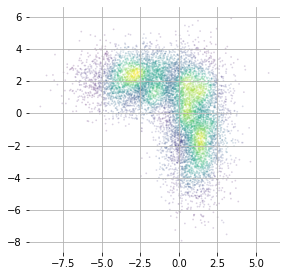

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.008049053192138672

##### dim = 500

Train

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

4/4 [==============================] - 0s 2ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1min 31s, sys: 1.45 s, total: 1min 33s
Wall time: 50 s


Scatter plot 

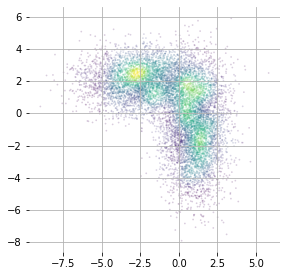

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.006143606948852539

##### dim = 1000

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

4/4 [==============================] - 0s 3ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 9min 56s, sys: 2.85 s, total: 9min 59s
Wall time: 5min 8s


Scatter plot 

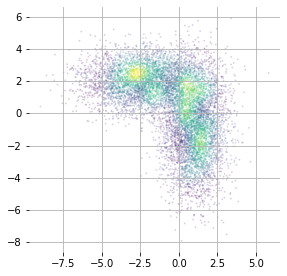

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.006299557113647461

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

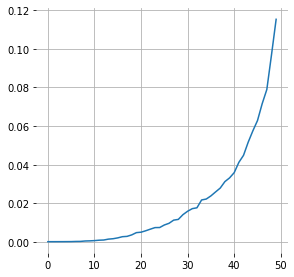

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_50.predict(X_test)

CPU times: user 592 ms, sys: 35.4 ms, total: 627 ms
Wall time: 530 ms


Scatter plot 

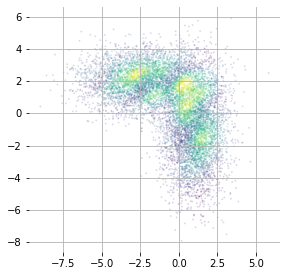

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.00995330047607422

##### dim = 100

Train

In [ ]:
num_eig = 100
dim = 100
sgd_model_100 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

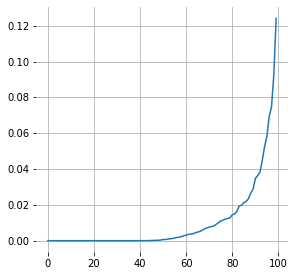

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_100.predict(X_test)

CPU times: user 511 ms, sys: 25.4 ms, total: 536 ms
Wall time: 418 ms


Scatter plot 

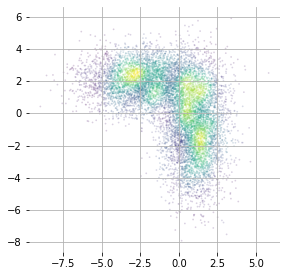

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.00804906005859375

##### dim = 500

Train

In [ ]:
num_eig = 100
dim = 500
sgd_model_500 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

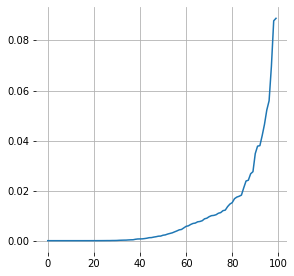

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_500.predict(X_test)

CPU times: user 735 ms, sys: 280 ms, total: 1.02 s
Wall time: 822 ms


Scatter plot 

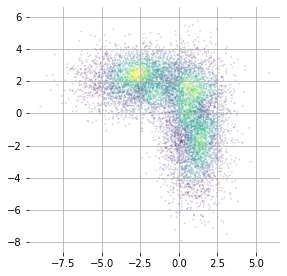

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.006143690490722656

##### dim = 1000

Train

In [ ]:
num_eig = 100
dim = 1000
sgd_model_1000 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

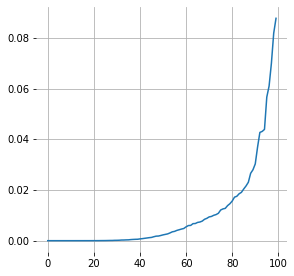

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_1000.predict(X_test)

CPU times: user 920 ms, sys: 486 ms, total: 1.41 s
Wall time: 1.37 s


Scatter plot 

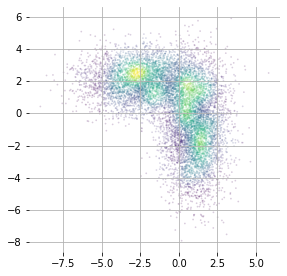

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.006300210571289063

## Experiment 3 : 1000

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 1000, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 2D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 2D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 2D data set shape is:(1000, 2) and their densities shape is (1000,)
Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)


Scatter plot of test data

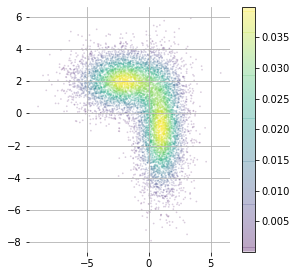

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = X_test_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.show()

### Fixing bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-10,10,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = bimix_gauss.prob(X_test_new).numpy()
    raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new])    
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Best gamma:2 with L1_error 0.00266567706049625


Fixed gamma

In [ ]:
gamma = 2

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.5

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test])

CPU times: user 550 ms, sys: 934 µs, total: 550 ms
Wall time: 553 ms


Scatter plot

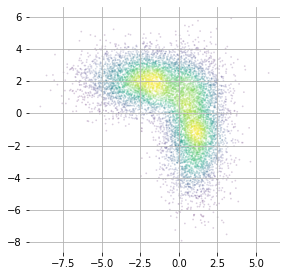

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = raw_kde_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

0.002370956091796225

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = NaiveKDE_density.evaluate(X_test)

CPU times: user 707 ms, sys: 2.92 ms, total: 710 ms
Wall time: 714 ms


Scatter plot

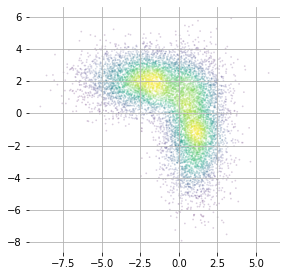

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = NaiveKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

0.0023709560917961406

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = TreeKDE_density.evaluate(X_test)

CPU times: user 3.63 s, sys: 27 ms, total: 3.66 s
Wall time: 3.65 s


Scatter plot

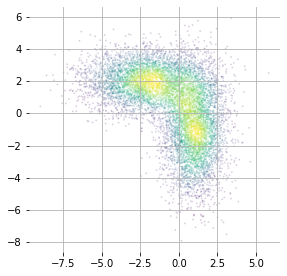

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = TreeKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

0.0023789930109295926

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = np.exp(KernelDensitybt_density.score_samples(X_test))

CPU times: user 641 ms, sys: 3.98 ms, total: 645 ms
Wall time: 648 ms


Scatter plot

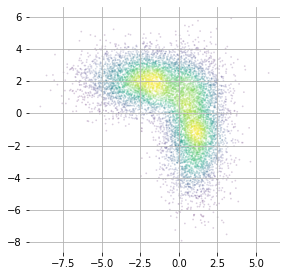

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitybt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

0.0023709560917964645

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = np.exp(KernelDensitykdt_density.score_samples(X_test))

CPU times: user 703 ms, sys: 2.9 ms, total: 706 ms
Wall time: 710 ms


Scatter plot

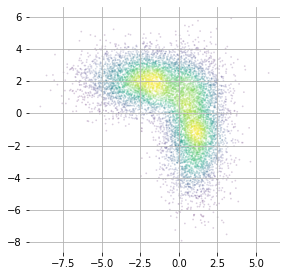

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitykdt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

0.0023709560917965365

#### `fastKDE`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time fastKDE_densities = fastKDE.pdf_at_points(X_train[:,0], X_train[:,1], list_of_points = X_test)

CPU times: user 14.7 s, sys: 16.7 ms, total: 14.7 s
Wall time: 14.7 s


Scatter plot

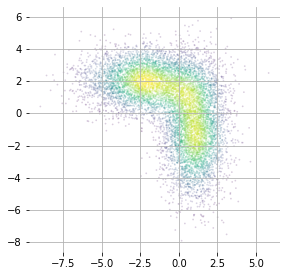

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = fastKDE_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(fastKDE_densities - X_test_densities))

0.0018904818710176437

#### `DMKDE`

##### dim = 50

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

32/32 [==============================] - 0s 961us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 656 ms, sys: 54.4 ms, total: 711 ms
Wall time: 611 ms


Scatter plot 

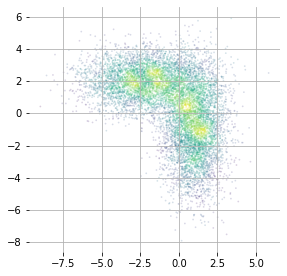

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.02064699859619141

##### dim = 100

Train

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

32/32 [==============================] - 0s 1ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1.63 s, sys: 424 ms, total: 2.05 s
Wall time: 1.64 s


Scatter plot 

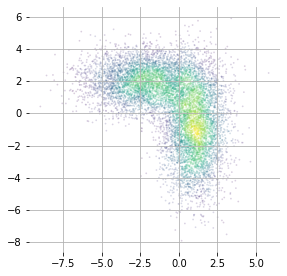

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.012382762908935547

##### dim = 500

Train

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

32/32 [==============================] - 0s 990us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1min 31s, sys: 5.91 s, total: 1min 37s
Wall time: 54.9 s


Scatter plot 

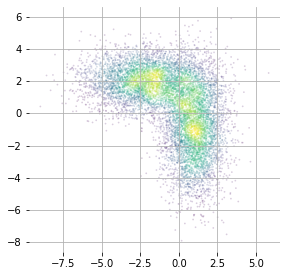

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.002630315399169922

##### dim = 1000

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

32/32 [==============================] - 0s 2ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 10min 3s, sys: 5.46 s, total: 10min 8s
Wall time: 5min 14s


Scatter plot 

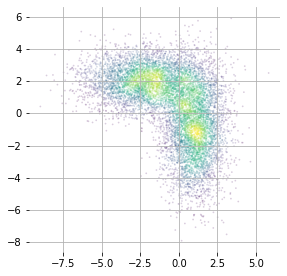

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.002618480110168457

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

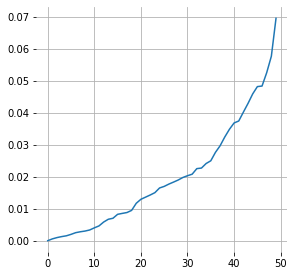

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_50.predict(X_test)

CPU times: user 461 ms, sys: 29.4 ms, total: 490 ms
Wall time: 391 ms


Scatter plot 

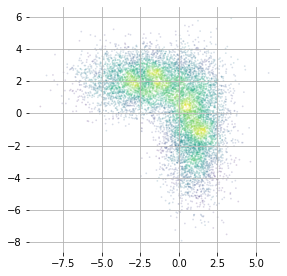

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.020647003173828126

##### dim = 100

Train

In [ ]:
num_eig = 100
dim = 100
sgd_model_100 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

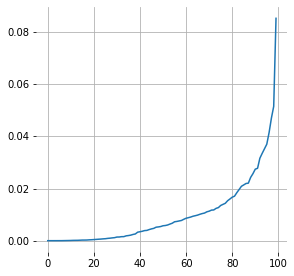

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_100.predict(X_test)

CPU times: user 507 ms, sys: 22.4 ms, total: 530 ms
Wall time: 411 ms


Scatter plot 

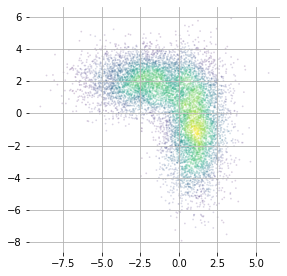

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.012382772064208986

##### dim = 500

Train

In [ ]:
num_eig = 300
dim = 500
sgd_model_500 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

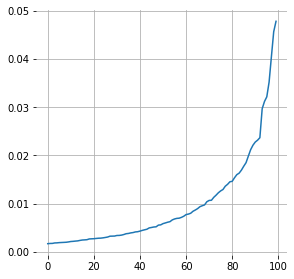

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_500.predict(X_test)

CPU times: user 1.66 s, sys: 296 ms, total: 1.96 s
Wall time: 1.43 s


Scatter plot 

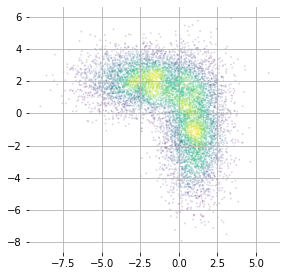

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.00263020133972168

##### dim = 1000

Train

In [ ]:
num_eig = 300
dim = 1000
sgd_model_1000 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

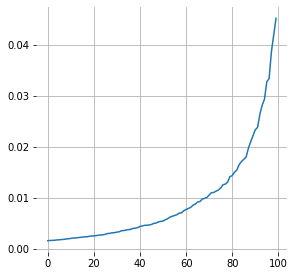

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_1000.predict(X_test)

CPU times: user 2.67 s, sys: 266 ms, total: 2.94 s
Wall time: 1.84 s


Scatter plot 

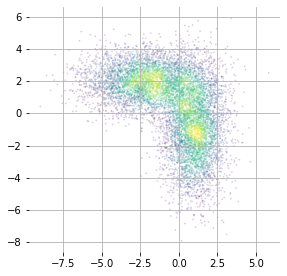

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.002616261863708496

## Experiment 4 : 10000

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 10000, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 2D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 2D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)
Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)


Scatter plot of test data

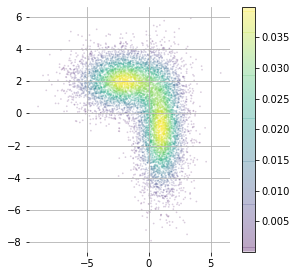

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = X_test_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.show()

### Fixing bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-10,10,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = bimix_gauss.prob(X_test_new).numpy()
    raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new])    
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Best gamma:4 with L1_error 0.0012880724657184193


Fixed gamma

In [ ]:
gamma = 4

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.35355339059327373

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test])

CPU times: user 4 s, sys: 6.78 ms, total: 4 s
Wall time: 4 s


Scatter plot

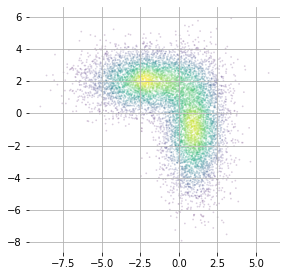

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = raw_kde_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

0.001207252375726895

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = NaiveKDE_density.evaluate(X_test)

CPU times: user 6.95 s, sys: 18.7 ms, total: 6.97 s
Wall time: 6.97 s


Scatter plot

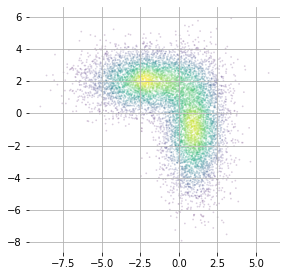

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = NaiveKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

0.0012072523757268448

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = TreeKDE_density.evaluate(X_test)

CPU times: user 6.36 s, sys: 26.7 ms, total: 6.38 s
Wall time: 6.37 s


Scatter plot

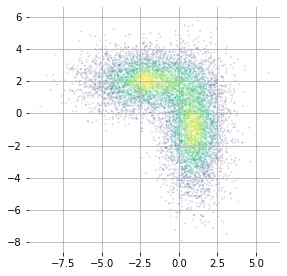

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = TreeKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

0.0012161408915165421

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = np.exp(KernelDensitybt_density.score_samples(X_test))

CPU times: user 5.11 s, sys: 12.7 ms, total: 5.12 s
Wall time: 5.11 s


Scatter plot

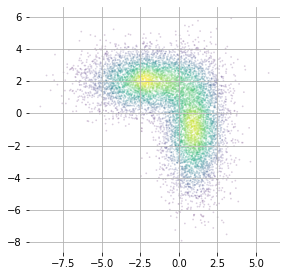

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitybt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

0.0012072523757294155

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = np.exp(KernelDensitykdt_density.score_samples(X_test))

CPU times: user 5 s, sys: 17.7 ms, total: 5.02 s
Wall time: 5.01 s


Scatter plot

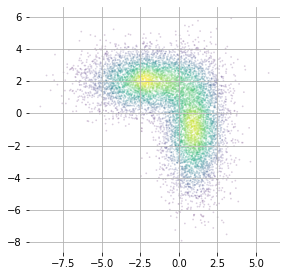

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitykdt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

0.0012072523757298682

#### `fastKDE`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time fastKDE_densities = fastKDE.pdf_at_points(X_train[:,0], X_train[:,1], list_of_points = X_test)

CPU times: user 29.2 s, sys: 9.32 ms, total: 29.2 s
Wall time: 29.1 s


Scatter plot

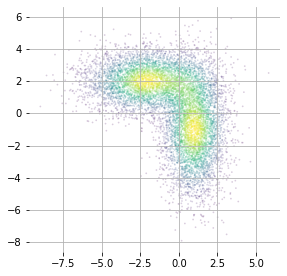

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = fastKDE_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(fastKDE_densities - X_test_densities))

0.0006713411056659969

#### `DMKDE`

##### dim = 50

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 2, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

313/313 [==============================] - 0s 860us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = 2, dimension = 2) 

CPU times: user 631 ms, sys: 62.6 ms, total: 693 ms
Wall time: 573 ms


Scatter plot 

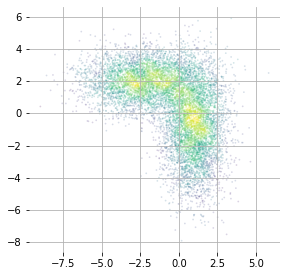

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.02080029754638672

##### dim = 100

Train

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 2, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

313/313 [==============================] - 0s 902us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = 2, dimension = 2) 

CPU times: user 1.56 s, sys: 116 ms, total: 1.67 s
Wall time: 1.28 s


Scatter plot 

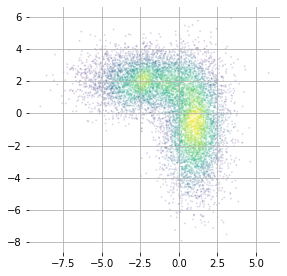

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.012505752563476562

##### dim = 500

Train

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 2, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

313/313 [==============================] - 0s 1ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = 2, dimension = 2) 

CPU times: user 1min 31s, sys: 1.42 s, total: 1min 33s
Wall time: 50.1 s


Scatter plot 

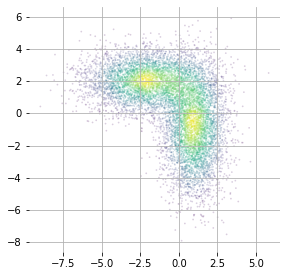

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.0016525808334350587

##### dim = 1000

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 2, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

313/313 [==============================] - 1s 2ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = 2, dimension = 2) 

CPU times: user 9min 53s, sys: 3.72 s, total: 9min 57s
Wall time: 5min 7s


Scatter plot 

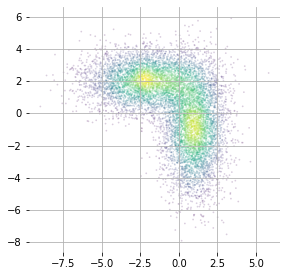

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.001712710952758789

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 2, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

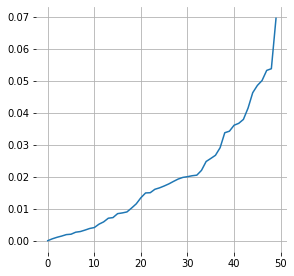

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 2,dimension = 2) * sgd_model_50.predict(X_test)

CPU times: user 443 ms, sys: 44.3 ms, total: 487 ms
Wall time: 376 ms


Scatter plot 

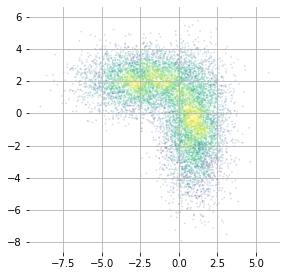

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.020800305175781252

##### dim = 100

Train

In [ ]:
num_eig = 100
dim = 100
sgd_model_100 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 2, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

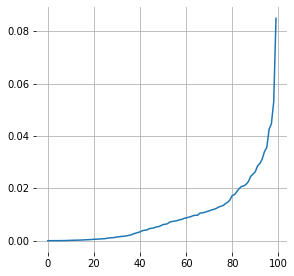

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 2,dimension = 2) * sgd_model_100.predict(X_test)

CPU times: user 494 ms, sys: 39.5 ms, total: 533 ms
Wall time: 736 ms


Scatter plot 

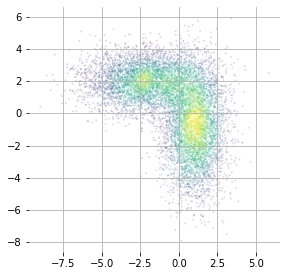

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.012505774688720704

##### dim = 500

Train

In [ ]:
num_eig = 500
dim = 500
sgd_model_500 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 2, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

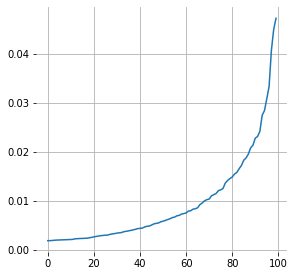

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 2,dimension = 2) * sgd_model_500.predict(X_test)

CPU times: user 3.56 s, sys: 166 ms, total: 3.72 s
Wall time: 2.35 s


Scatter plot 

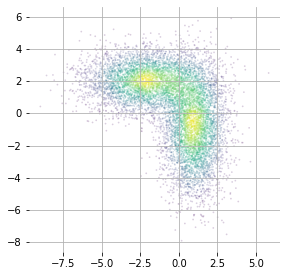

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.0016522647857666016

##### dim = 1000

Train

In [ ]:
num_eig = 700
dim = 1000
sgd_model_1000 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 2, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

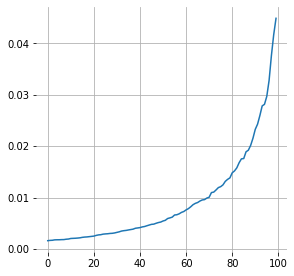

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 2,dimension = 2) * sgd_model_1000.predict(X_test)

CPU times: user 10.2 s, sys: 184 ms, total: 10.4 s
Wall time: 5.96 s


Scatter plot 

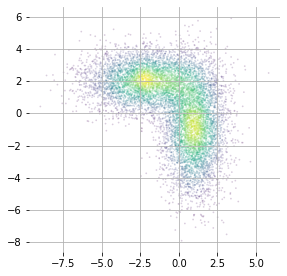

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.0017070825576782228

## Experiment 5 : 100000

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 100000, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 2D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 2D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 2D data set shape is:(100000, 2) and their densities shape is (100000,)
Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)


Scatter plot of test data

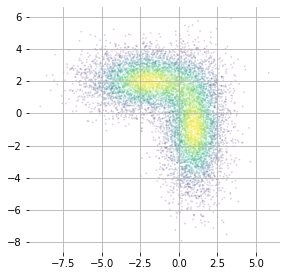

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = X_test_densities, alpha=.2,s = 3, linewidths= 0.0000001)
#plt.colorbar()
plt.savefig('testdensities_2Dmixt.png',dpi = 300)
plt.show()

### Fixing bandwidth - Use 10.000 bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-10,10,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = bimix_gauss.prob(X_test_new).numpy()
    raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new])    
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Best gamma:32 with L1_error 0.006412727219440295


Fixed gamma

In [ ]:
gamma = 4

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.35355339059327373

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test])

CPU times: user 50 s, sys: 499 ms, total: 50.5 s
Wall time: 50.4 s


Scatter plot

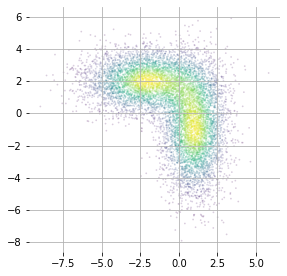

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = raw_kde_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_2Dmixt_rawkde100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

0.0010447760176589766

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = NaiveKDE_density.evaluate(X_test)

CPU times: user 1min 39s, sys: 252 ms, total: 1min 39s
Wall time: 1min 39s


Scatter plot

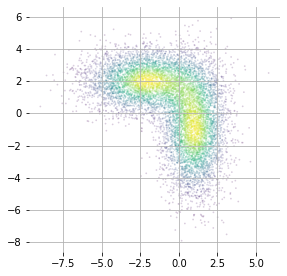

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = NaiveKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_2Dmixt_naivekde100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

0.0010447760176592047

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = TreeKDE_density.evaluate(X_test)

CPU times: user 48.1 s, sys: 207 ms, total: 48.3 s
Wall time: 48.2 s


Scatter plot

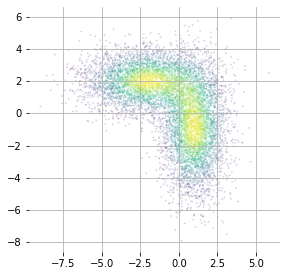

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = TreeKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_2Dmixt_treekde100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

0.0010670044800806678

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = np.exp(KernelDensitybt_density.score_samples(X_test))

CPU times: user 1min 2s, sys: 163 ms, total: 1min 2s
Wall time: 1min 1s


Scatter plot

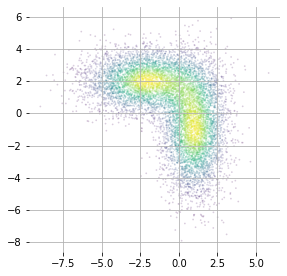

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitybt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_2Dmixt_kerneldensitybtkde100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

0.0010447760176963388

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = np.exp(KernelDensitykdt_density.score_samples(X_test))

CPU times: user 1min 11s, sys: 245 ms, total: 1min 11s
Wall time: 1min 11s


Scatter plot

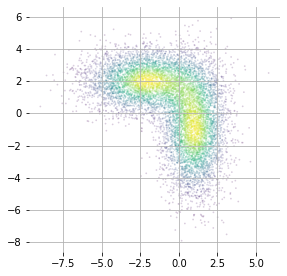

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitykdt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_2Dmixt_kerneldensitykdtkde100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

0.0010447760176965563

#### `fastKDE`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time fastKDE_densities = fastKDE.pdf_at_points(X_train[:,0], X_train[:,1], list_of_points = X_test)

CPU times: user 58.7 s, sys: 44.3 ms, total: 58.8 s
Wall time: 58.6 s


Scatter plot

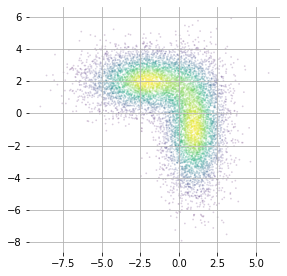

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = fastKDE_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(fastKDE_densities - X_test_densities))

0.00025039607960032043

#### `DMKDE`

##### dim = 50

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 2, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

3125/3125 [==============================] - 3s 804us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = 2, dimension = 2) 

CPU times: user 656 ms, sys: 64.5 ms, total: 720 ms
Wall time: 603 ms


Scatter plot 

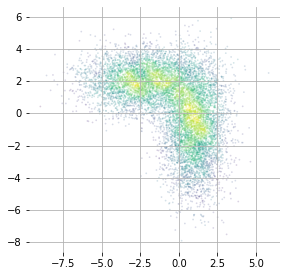

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.020857965087890624

##### dim = 100

Train

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 2, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

3125/3125 [==============================] - 3s 821us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = 2, dimension = 2) 

CPU times: user 1.61 s, sys: 115 ms, total: 1.73 s
Wall time: 1.33 s


Scatter plot 

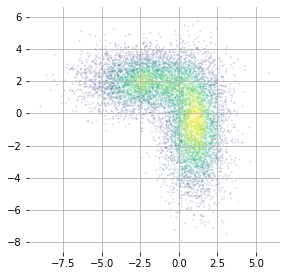

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.012506048583984375

##### dim = 500

Train

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 2, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

3125/3125 [==============================] - 6s 1ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = 2, dimension = 2) 

CPU times: user 1min 31s, sys: 1.97 s, total: 1min 33s
Wall time: 50.7 s


Scatter plot 

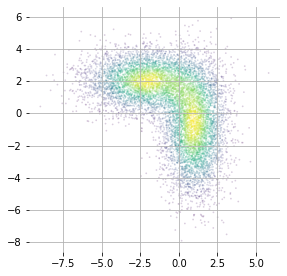

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.0016070379257202149

##### dim = 1000

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 2, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

3125/3125 [==============================] - 10s 3ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = 2, dimension = 2) 

CPU times: user 10min 3s, sys: 3.01 s, total: 10min 6s
Wall time: 5min 12s


Scatter plot 

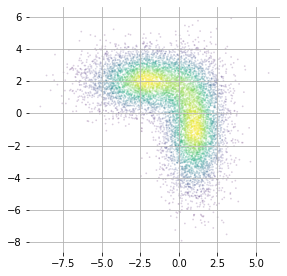

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.0015599903106689455

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 2, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

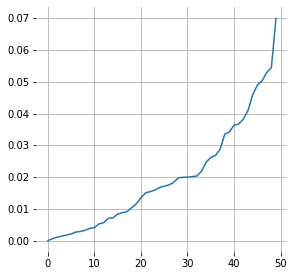

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 2,dimension = 2) * sgd_model_50.predict(X_test)

CPU times: user 456 ms, sys: 41.2 ms, total: 498 ms
Wall time: 420 ms


Scatter plot 

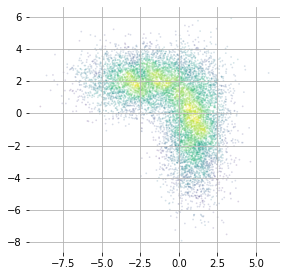

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.02085797119140625

##### dim = 100

Train

In [ ]:
num_eig = 100
dim = 100
sgd_model_100 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 2, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

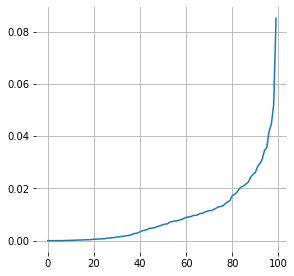

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 2,dimension = 2) * sgd_model_100.predict(X_test)

CPU times: user 484 ms, sys: 41.4 ms, total: 526 ms
Wall time: 421 ms


Scatter plot 

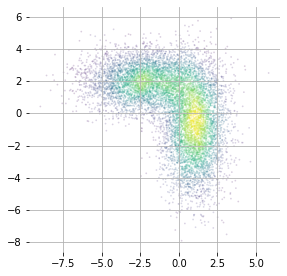

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.012506061553955079

##### dim = 500

Train

In [ ]:
num_eig = 500
dim = 500
sgd_model_500 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 2, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

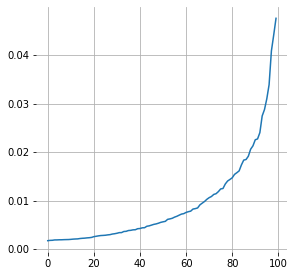

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 2,dimension = 2) * sgd_model_500.predict(X_test)

CPU times: user 4.28 s, sys: 135 ms, total: 4.41 s
Wall time: 2.72 s


Scatter plot 

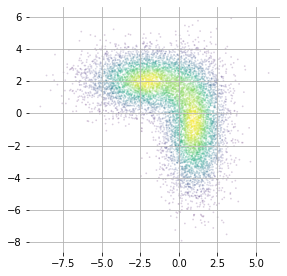

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.0016066780090332033

##### dim = 1000

Train

In [ ]:
num_eig = 700
dim = 1000
sgd_model_1000 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 2, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

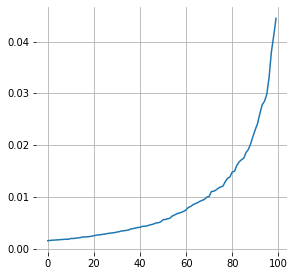

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 2,dimension = 2) * sgd_model_1000.predict(X_test)

CPU times: user 11.9 s, sys: 262 ms, total: 12.2 s
Wall time: 7.36 s


Scatter plot 

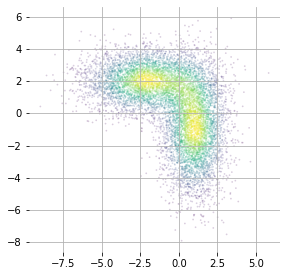

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_2Dmixt_eigdmkde1000100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.0015532487869262695

## Final timing plot

In [ ]:
plt.rcParams["figure.figsize"] = (20*0.75,15*0.75)

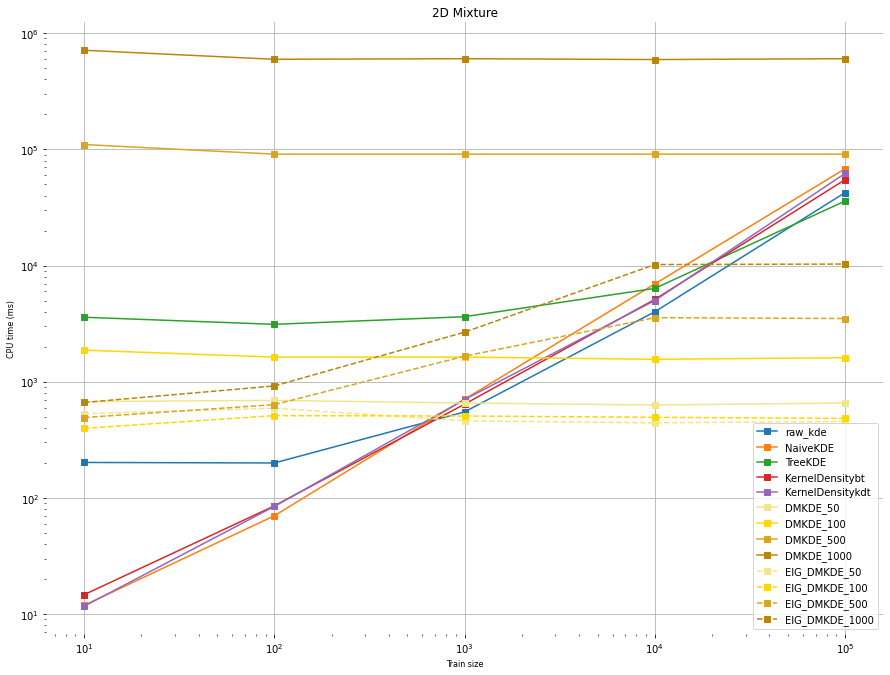

In [ ]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
CPU_time_raw_kde = [202,200,550,4000,42400]
#NaiveKDE
CPU_time_NaiveKDE = [11.9,70.2,707,6950,68000]
#TreeKDE
CPU_time_TreeKDE = [3590,3120,3630,6360,35900]
#KernelDensitybt
CPU_time_KernelDensitybt = [14.7,85.4,641,5110,54800]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [11.7,84.5,703,5000,62000]
#fastKDE
#CPU_time_fastKDE = [9030,14700,14700,29200,58700]
#DMKDE_50
CPU_time_DMKDE_50 = [675,691,656,631,656]
#DMKDE_100
CPU_time_DMKDE_100 = [1870,1630,1630,1560,1610]
#DMKDE_500
CPU_time_DMKDE_500 = [110000,91000,91000,91000,91000]
#DMKDE_1000
CPU_time_DMKDE_1000 = [713000,596000,603000,593000,603000]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [531,592,461,443,456]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [397,511,507,494,484]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [492,635,1660,3560,3500]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [663,920,2670,10200,10300]

plt.axes(frameon = 0)
plt.grid()
plt.plot(train_size,CPU_time_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,CPU_time_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,CPU_time_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,CPU_time_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,CPU_time_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
#plt.plot(train_size,CPU_time_fastKDE, c = 'tab:brown', marker = 's', label = 'fastKDE')
plt.plot(train_size,CPU_time_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
plt.plot(train_size,CPU_time_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
plt.plot(train_size,CPU_time_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,CPU_time_DMKDE_1000, c = 'darkgoldenrod', marker = 's', label = 'DMKDE_1000')
plt.plot(train_size,CPU_time_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
plt.plot(train_size,CPU_time_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
plt.plot(train_size,CPU_time_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,CPU_time_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('CPU time (ms)')
plt.title('2D Mixture')
plt.savefig('time_2Dmixt.png', dpi=300)
plt.show()

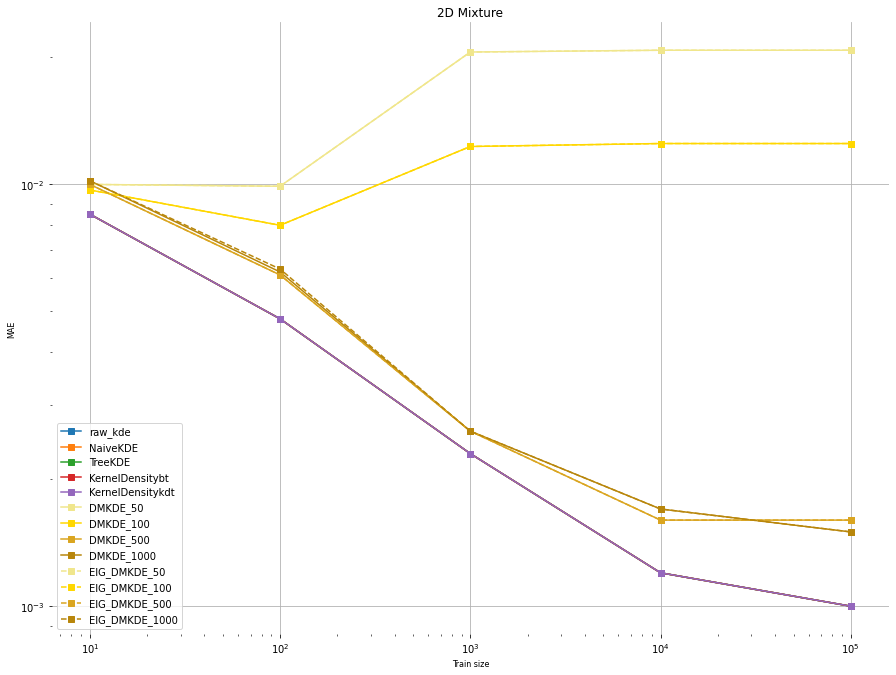

In [ ]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
error_raw_kde = [0.0085,0.0048,0.0023,0.0012,0.0010]
#NaiveKDE
error_NaiveKDE = [0.0085,0.0048,0.0023,0.0012,0.0010]
#TreeKDE
error_TreeKDE = [0.0085,0.0048,0.0023,0.0012,0.0010]
#KernelDensitybt
error_KernelDensitybt = [0.0085,0.0048,0.0023,0.0012,0.0010]
#KernelDensitykdt
error_KernelDensitykdt = [0.0085,0.0048,0.0023,0.0012,0.0010]
#fastKDE
#error_fastKDE = [0.0123,0.0062,0.0018,0.0006,0.0002]
#DMKDE_50
error_DMKDE_50 = [0.0100,0.0099,0.0206,0.0208,0.0208]
#DMKDE_100
error_DMKDE_100 = [0.0097,0.0080,0.0123,0.0125,0.0125]
#DMKDE_500
error_DMKDE_500 = [0.0100,0.0061,0.0026,0.0016,0.0016]
#DMKDE_1000
error_DMKDE_1000 = [0.0102,0.0062,0.0026,0.0017,0.0015]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0100,0.0099,0.0206,0.0208,0.0208]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0097,0.0080,0.0123,0.0125,0.0125]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0100,0.0061,0.0026,0.0016,0.0016]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.0102,0.0063,0.0026,0.0017,0.0015]

plt.axes(frameon = 0)
plt.grid()
plt.plot(train_size,error_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,error_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,error_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,error_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,error_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
#plt.plot(train_size,error_fastKDE, c = 'tab:brown', marker = 's', label = 'fastKDE')
plt.plot(train_size,error_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
plt.plot(train_size,error_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
plt.plot(train_size,error_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,error_DMKDE_1000, c = 'darkgoldenrod', marker = 's', label = 'DMKDE_1000')
plt.plot(train_size,error_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
plt.plot(train_size,error_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
plt.plot(train_size,error_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,error_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('MAE')
plt.title('2D Mixture')
plt.savefig('mae_2Dmixt.png', dpi=300)
plt.show()

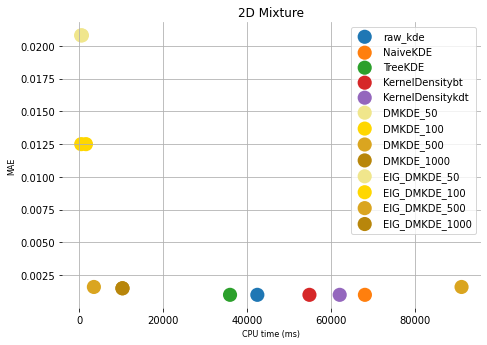

In [ ]:
#raw_kde
CPU_time_raw_kde = [202,200,550,4000,42400][4]
#NaiveKDE
CPU_time_NaiveKDE = [11.9,70.2,707,6950,68000][4]
#TreeKDE
CPU_time_TreeKDE = [3590,3120,3630,6360,35900][4]
#KernelDensitybt
CPU_time_KernelDensitybt = [14.7,85.4,641,5110,54800][4]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [11.7,84.5,703,5000,62000][4]
#fastKDE
#CPU_time_fastKDE = [9030,14700,14700,29200,58700][4]
#DMKDE_50
CPU_time_DMKDE_50 = [675,691,656,631,656][4]
#DMKDE_100
CPU_time_DMKDE_100 = [1870,1630,1630,1560,1610][4]
#DMKDE_500
CPU_time_DMKDE_500 = [110000,91000,91000,91000,91000][4]
#DMKDE_1000
CPU_time_DMKDE_1000 = [713000,596000,603000,593000,603000][4]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [531,592,461,443,456][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [397,511,507,494,484][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [492,635,1660,3560,3500][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [663,920,2670,10200,10300][4]


#raw_kde
error_raw_kde = [0.0085,0.0048,0.0023,0.0012,0.0010][4]
#NaiveKDE
error_NaiveKDE = [0.0085,0.0048,0.0023,0.0012,0.0010][4]
#TreeKDE
error_TreeKDE = [0.0085,0.0048,0.0023,0.0012,0.0010][4]
#KernelDensitybt
error_KernelDensitybt = [0.0085,0.0048,0.0023,0.0012,0.0010][4]
#KernelDensitykdt
error_KernelDensitykdt = [0.0085,0.0048,0.0023,0.0012,0.0010][4]
#fastKDE
#error_fastKDE = [0.0123,0.0062,0.0018,0.0006,0.0002][4]
#DMKDE_50
error_DMKDE_50 = [0.0100,0.0099,0.0206,0.0208,0.0208][4]
#DMKDE_100
error_DMKDE_100 = [0.0097,0.0080,0.0123,0.0125,0.0125][4]
#DMKDE_500
error_DMKDE_500 = [0.0100,0.0061,0.0026,0.0016,0.0016][4]
#DMKDE_1000
error_DMKDE_1000 = [0.0102,0.0062,0.0026,0.0017,0.0015][4]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0100,0.0099,0.0206,0.0208,0.0208][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0097,0.0080,0.0123,0.0125,0.0125][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0100,0.0061,0.0026,0.0016,0.0016][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.0102,0.0063,0.0026,0.0017,0.0015][4]

plt.rcParams["figure.figsize"] = (10*0.75, 7*0.75)

scatter_100m = np.array([[CPU_time_raw_kde,error_raw_kde],
                [CPU_time_NaiveKDE,error_NaiveKDE],
                [CPU_time_TreeKDE,error_TreeKDE],
                [CPU_time_KernelDensitybt,error_KernelDensitybt],
                [CPU_time_KernelDensitykdt,error_KernelDensitykdt],
                [CPU_time_DMKDE_50,error_DMKDE_50],
                [CPU_time_DMKDE_100,error_DMKDE_100],
                [CPU_time_DMKDE_500,error_DMKDE_500],
                [CPU_time_EIG_DMKDE_1000,error_DMKDE_1000],
                [CPU_time_EIG_DMKDE_50,error_DMKDE_50],
                [CPU_time_EIG_DMKDE_100,error_DMKDE_100],
                [CPU_time_EIG_DMKDE_500,error_DMKDE_500],
                [CPU_time_EIG_DMKDE_1000,error_DMKDE_1000]
                ]).T

labels = ['raw_kde','NaiveKDE','TreeKDE','KernelDensitybt','KernelDensitykdt','DMKDE_50','DMKDE_100','DMKDE_500','DMKDE_1000','EIG_DMKDE_50','EIG_DMKDE_100'
,'EIG_DMKDE_500','EIG_DMKDE_1000']

colors = np.array(['tab:blue','tab:orange','tab:green','tab:red','tab:purple','khaki','gold','goldenrod','darkgoldenrod','khaki','gold','goldenrod','darkgoldenrod'])

#
fig, ax = plt.subplots()
j=0
for color,label in zip(colors,labels):
    x, y = (scatter_100m[0][j],scatter_100m[1][j])
    ax.grid(True)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.scatter(x, y, c= color, label= label,s = 200, edgecolors='none')
    j+=1
ax.set_xlabel('CPU time (ms)')
ax.set_ylabel('MAE')
ax.set_title('2D Mixture')
ax.grid(b=True)
ax.legend(loc = 1)
fig.savefig('eff_2Dmixt.svg')

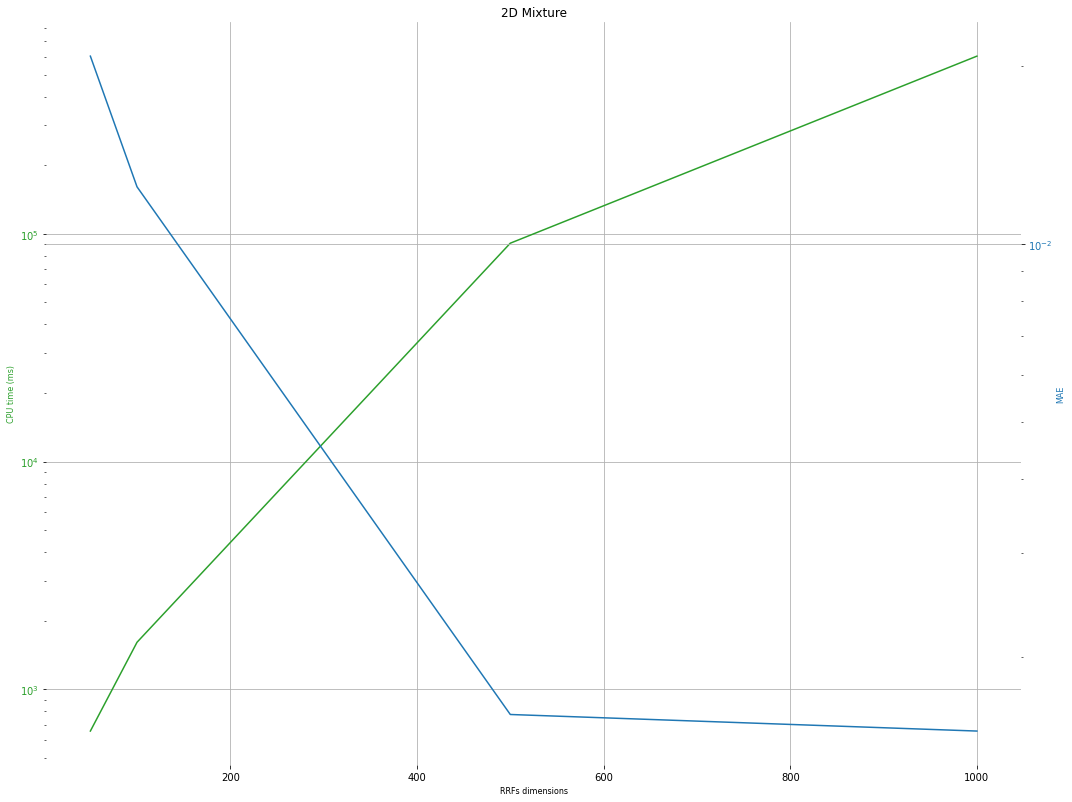

In [ ]:
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [531,592,461,443,456][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [397,511,507,494,484][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [492,635,1660,3560,3500][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [663,920,2670,10200,10300][4]

#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0100,0.0099,0.0206,0.0208,0.0208][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0097,0.0080,0.0123,0.0125,0.0125][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0100,0.0061,0.0026,0.0016,0.0016][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.0102,0.0063,0.0026,0.0017,0.0015][4]
t = [50.,100.,500.,1000.]
data1 = [CPU_time_DMKDE_50,CPU_time_DMKDE_100,CPU_time_DMKDE_500,CPU_time_DMKDE_1000]
data2 = [error_EIG_DMKDE_50,error_EIG_DMKDE_100,error_EIG_DMKDE_500,error_EIG_DMKDE_1000]

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_title('2D Mixture')
ax1.grid(True)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.set_xlabel('RRFs dimensions')
ax1.set_ylabel('CPU time (ms)', color=color)
ax1.set_yscale('log')
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.grid(True)
ax2.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.set_ylabel('MAE', color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('rff_2Dmixt.png', dpi=300)
plt.show()

## Final timing plot

In [10]:
!pip install SciencePlots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for SciencePlots: filename=SciencePlots-1.0.9-py3-none-any.whl size=6484 sha256=606c04b88b83cb9710f06794fbc569e82fb16f5914de97821369c99c32f9a386
  Stored in directory: /root/.cache/pip/wheels/37/f8/e9/b2f53a40b336388dfc57b108150daff7d6ffbbfc618dba3924
Successfully built SciencePlots


In [11]:
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
!pip install latex

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

In [12]:
plt.style.reload_library()
plt.style.use(['science','ieee','no-latex'])

In [13]:
size = (5,4)

In [14]:
plt.rcParams["figure.figsize"] = size

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


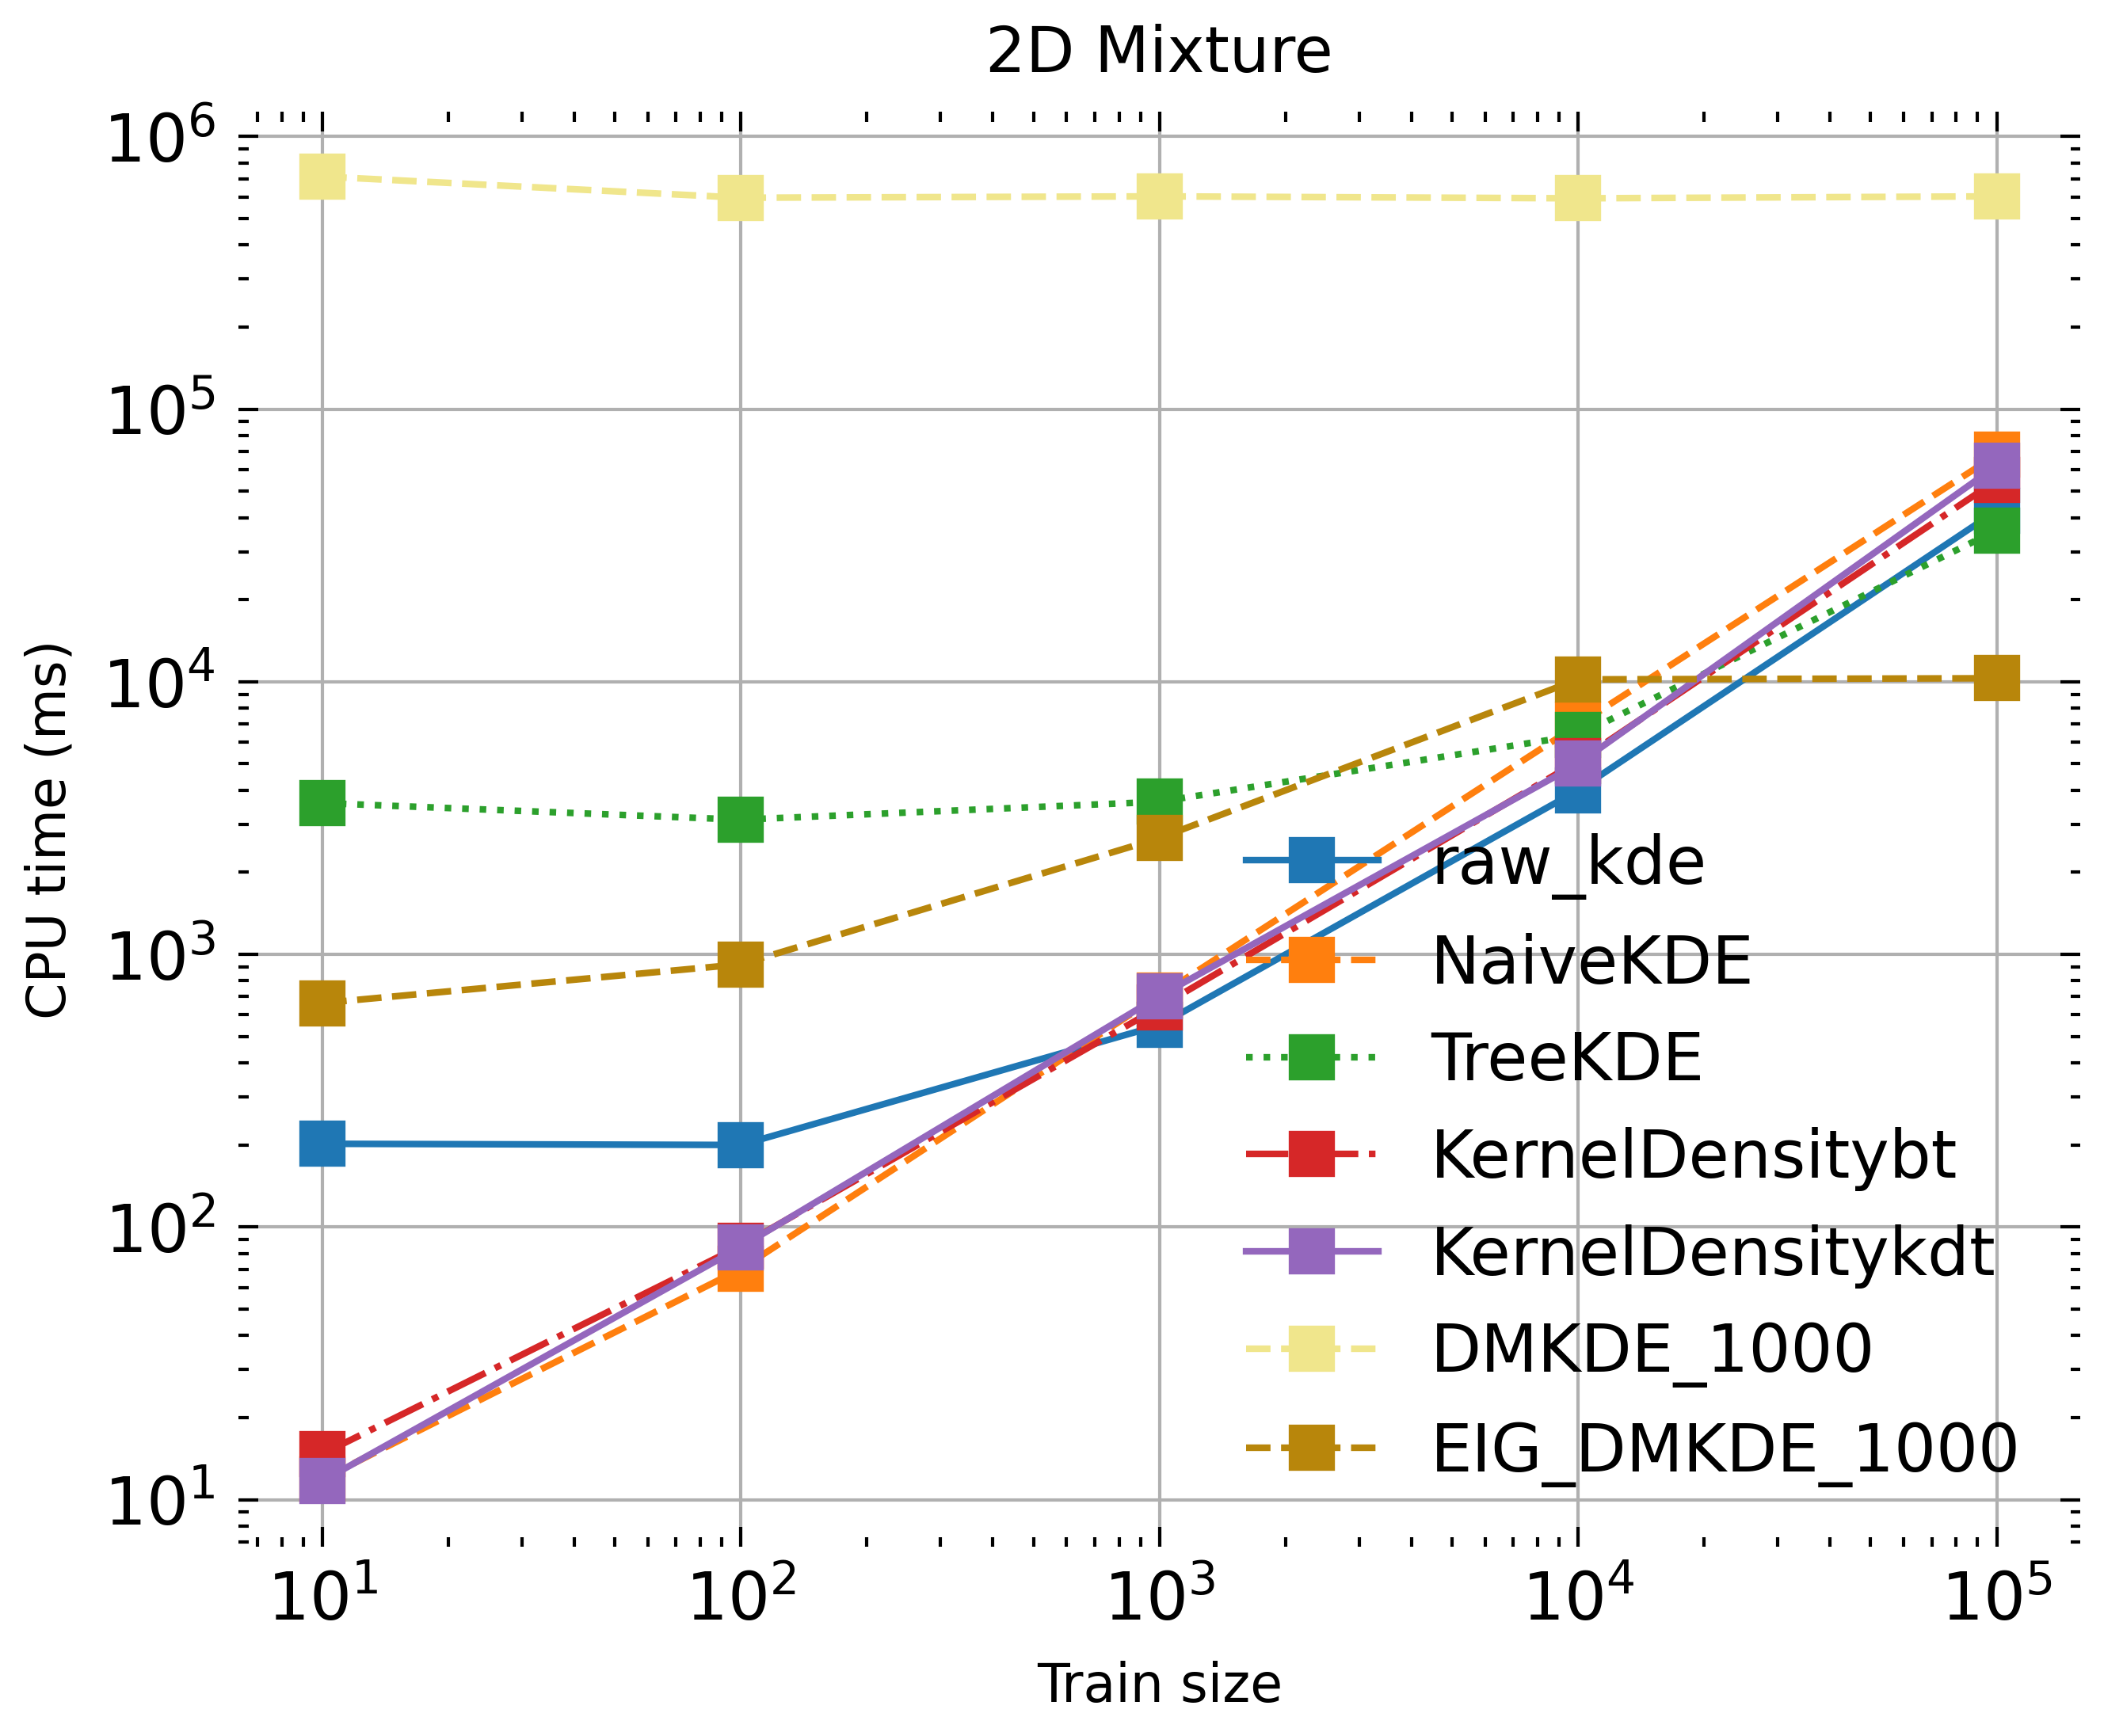

In [15]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
CPU_time_raw_kde = [202,200,550,4000,42400]
#NaiveKDE
CPU_time_NaiveKDE = [11.9,70.2,707,6950,68000]
#TreeKDE
CPU_time_TreeKDE = [3590,3120,3630,6360,35900]
#KernelDensitybt
CPU_time_KernelDensitybt = [14.7,85.4,641,5110,54800]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [11.7,84.5,703,5000,62000]
#fastKDE
#CPU_time_fastKDE = [9030,14700,14700,29200,58700]
#DMKDE_50
CPU_time_DMKDE_50 = [675,691,656,631,656]
#DMKDE_100
CPU_time_DMKDE_100 = [1870,1630,1630,1560,1610]
#DMKDE_500
CPU_time_DMKDE_500 = [110000,91000,91000,91000,91000]
#DMKDE_1000
CPU_time_DMKDE_1000 = [713000,596000,603000,593000,603000]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [531,592,461,443,456]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [397,511,507,494,484]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [492,635,1660,3560,3500]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [663,920,2670,10200,10300]

plt.axes(frameon = 0)
plt.grid()
plt.plot(train_size,CPU_time_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,CPU_time_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,CPU_time_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,CPU_time_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,CPU_time_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
#plt.plot(train_size,CPU_time_fastKDE, c = 'tab:brown', marker = 's', label = 'fastKDE')
#plt.plot(train_size,CPU_time_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
#plt.plot(train_size,CPU_time_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
#plt.plot(train_size,CPU_time_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,CPU_time_DMKDE_1000, c = 'khaki', marker = 's', label = 'DMKDE_1000')
#plt.plot(train_size,CPU_time_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
#plt.plot(train_size,CPU_time_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
#plt.plot(train_size,CPU_time_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,CPU_time_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('CPU time (ms)')
plt.title('2D Mixture')
plt.savefig('time_2Dmixt.png', dpi=300)
plt.show()

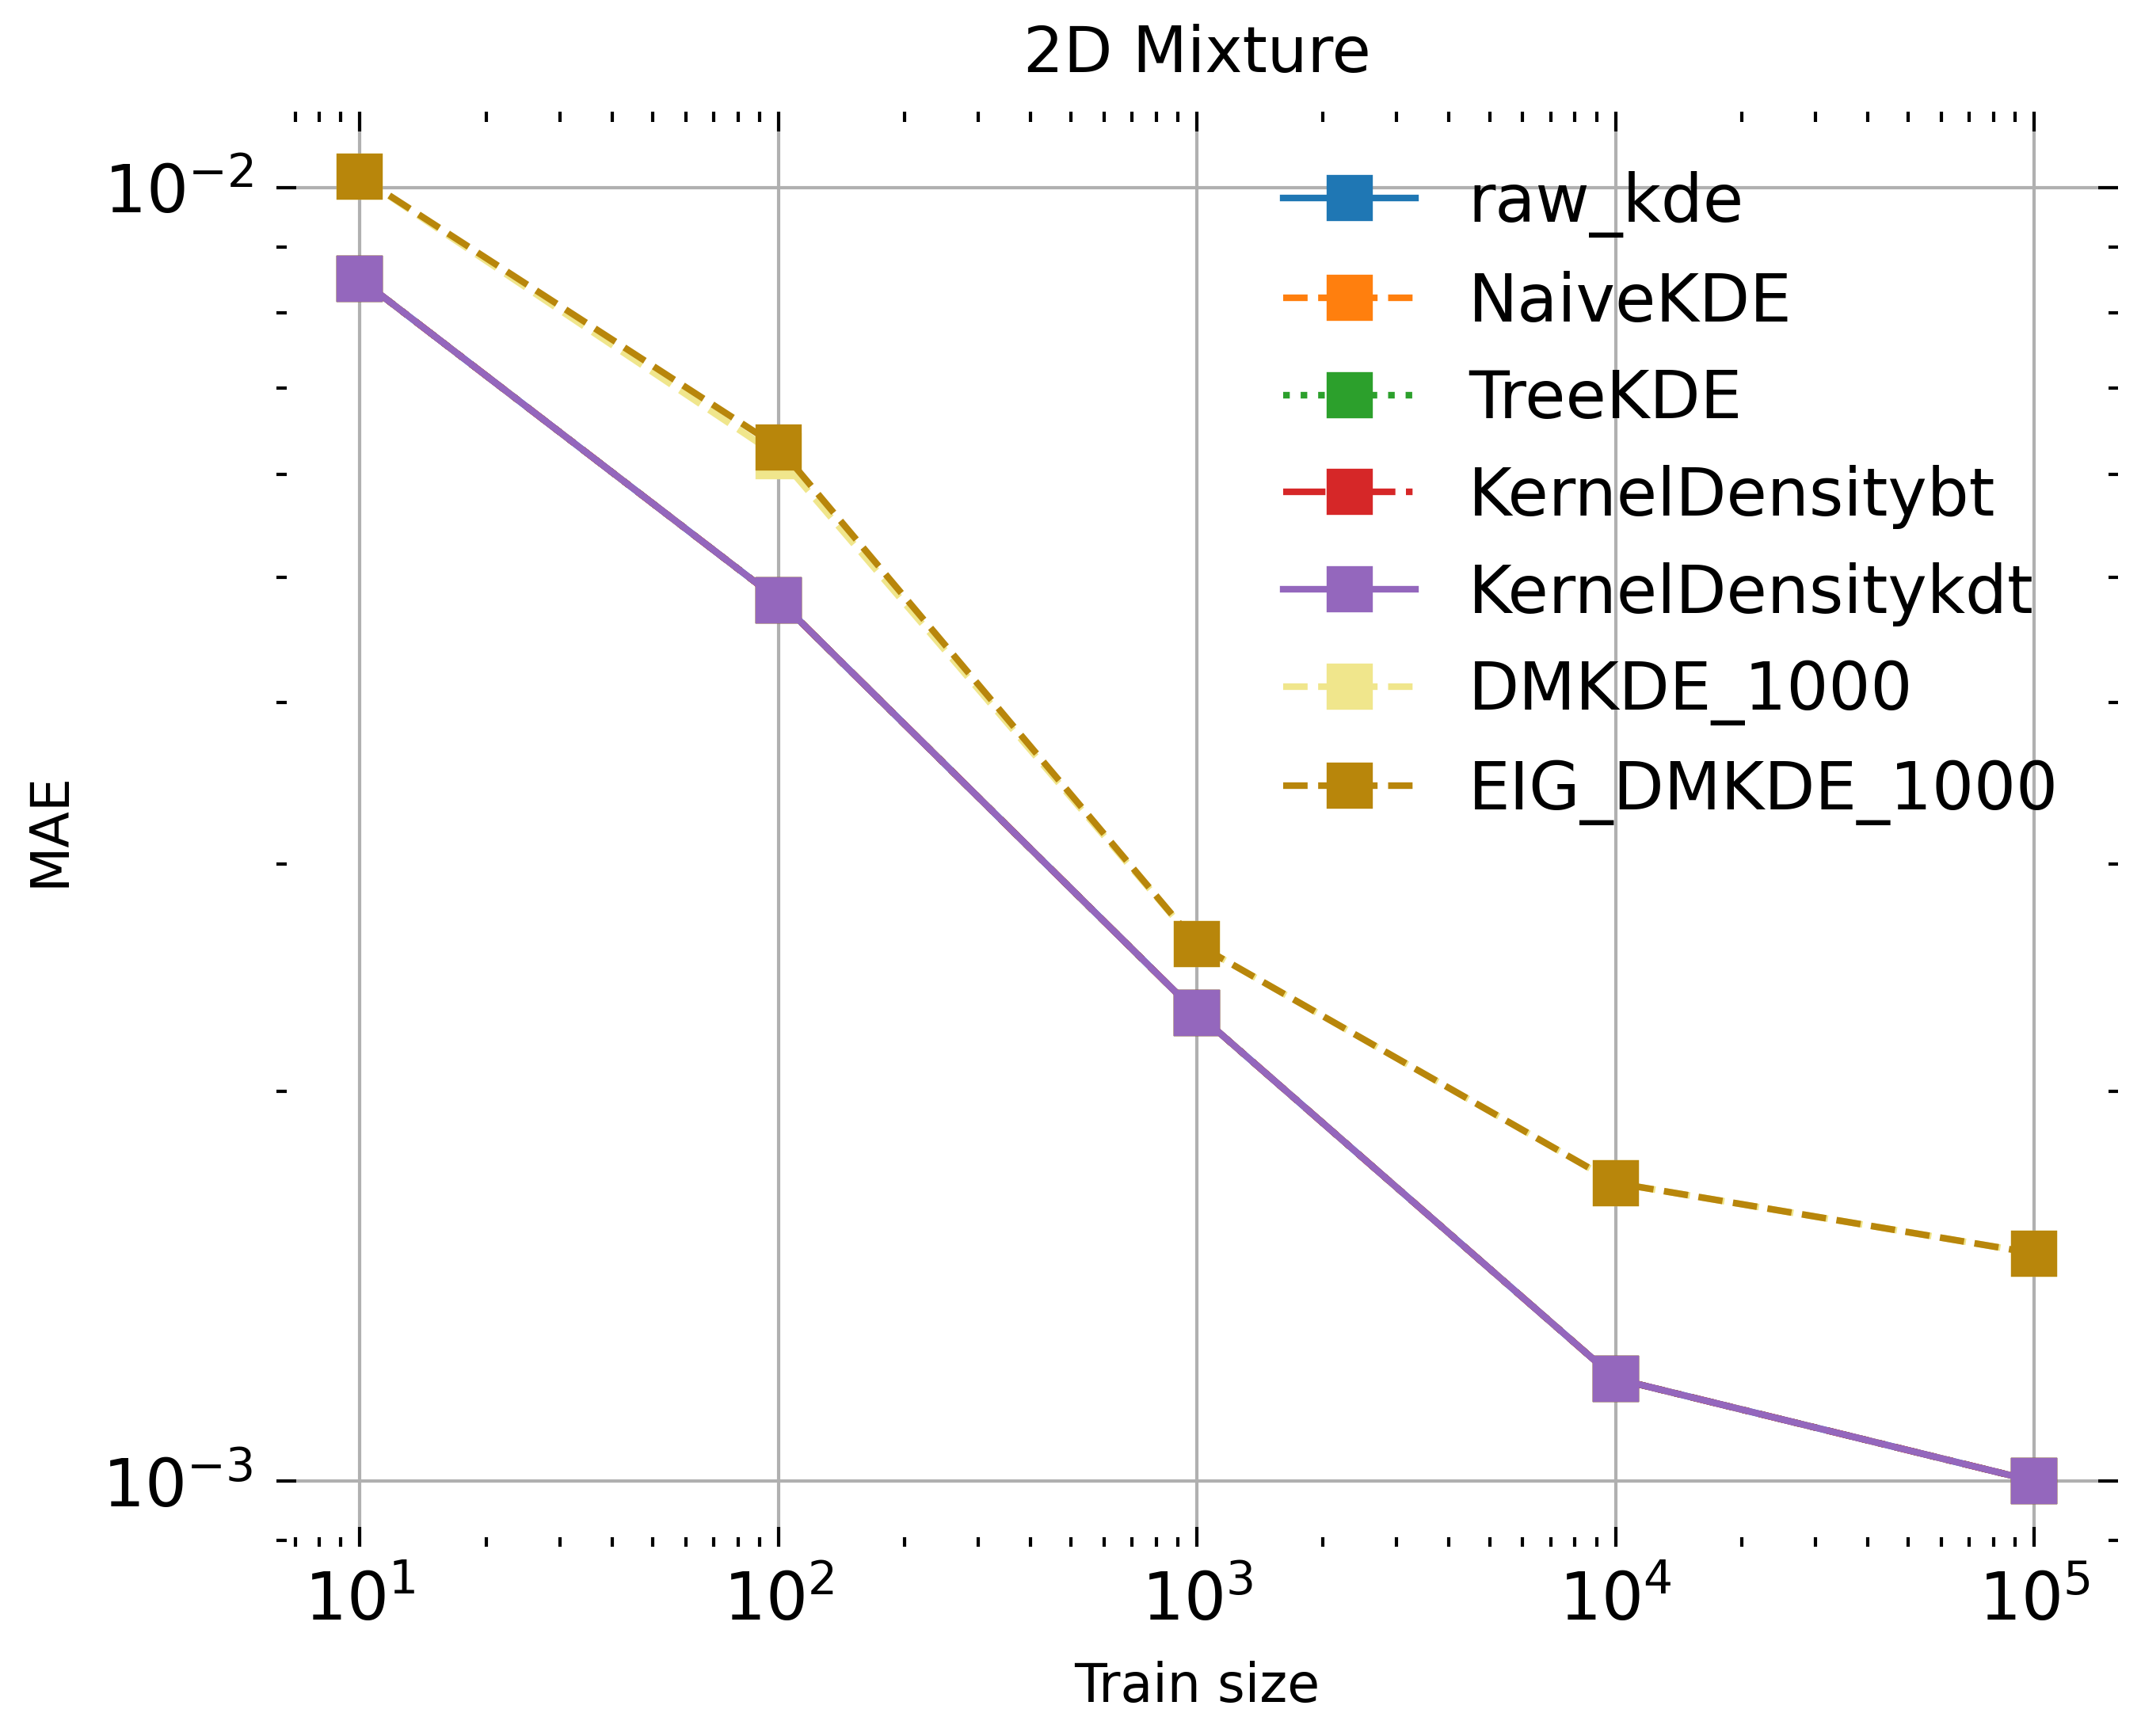

In [16]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
error_raw_kde = [0.0085,0.0048,0.0023,0.0012,0.0010]
#NaiveKDE
error_NaiveKDE = [0.0085,0.0048,0.0023,0.0012,0.0010]
#TreeKDE
error_TreeKDE = [0.0085,0.0048,0.0023,0.0012,0.0010]
#KernelDensitybt
error_KernelDensitybt = [0.0085,0.0048,0.0023,0.0012,0.0010]
#KernelDensitykdt
error_KernelDensitykdt = [0.0085,0.0048,0.0023,0.0012,0.0010]
#fastKDE
#error_fastKDE = [0.0123,0.0062,0.0018,0.0006,0.0002]
#DMKDE_50
error_DMKDE_50 = [0.0100,0.0099,0.0206,0.0208,0.0208]
#DMKDE_100
error_DMKDE_100 = [0.0097,0.0080,0.0123,0.0125,0.0125]
#DMKDE_500
error_DMKDE_500 = [0.0100,0.0061,0.0026,0.0016,0.0016]
#DMKDE_1000
error_DMKDE_1000 = [0.0102,0.0062,0.0026,0.0017,0.0015]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0100,0.0099,0.0206,0.0208,0.0208]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0097,0.0080,0.0123,0.0125,0.0125]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0100,0.0061,0.0026,0.0016,0.0016]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.0102,0.0063,0.0026,0.0017,0.0015]

plt.axes(frameon = 0)
plt.grid()
plt.plot(train_size,error_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,error_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,error_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,error_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,error_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
#plt.plot(train_size,error_fastKDE, c = 'tab:brown', marker = 's', label = 'fastKDE')
#plt.plot(train_size,error_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
#plt.plot(train_size,error_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
#plt.plot(train_size,error_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,error_DMKDE_1000, c = 'khaki', marker = 's', label = 'DMKDE_1000')
#plt.plot(train_size,error_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
#plt.plot(train_size,error_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
#plt.plot(train_size,error_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,error_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('MAE')
plt.title('2D Mixture')
plt.savefig('mae_2Dmixt.png', dpi=300)
plt.show()

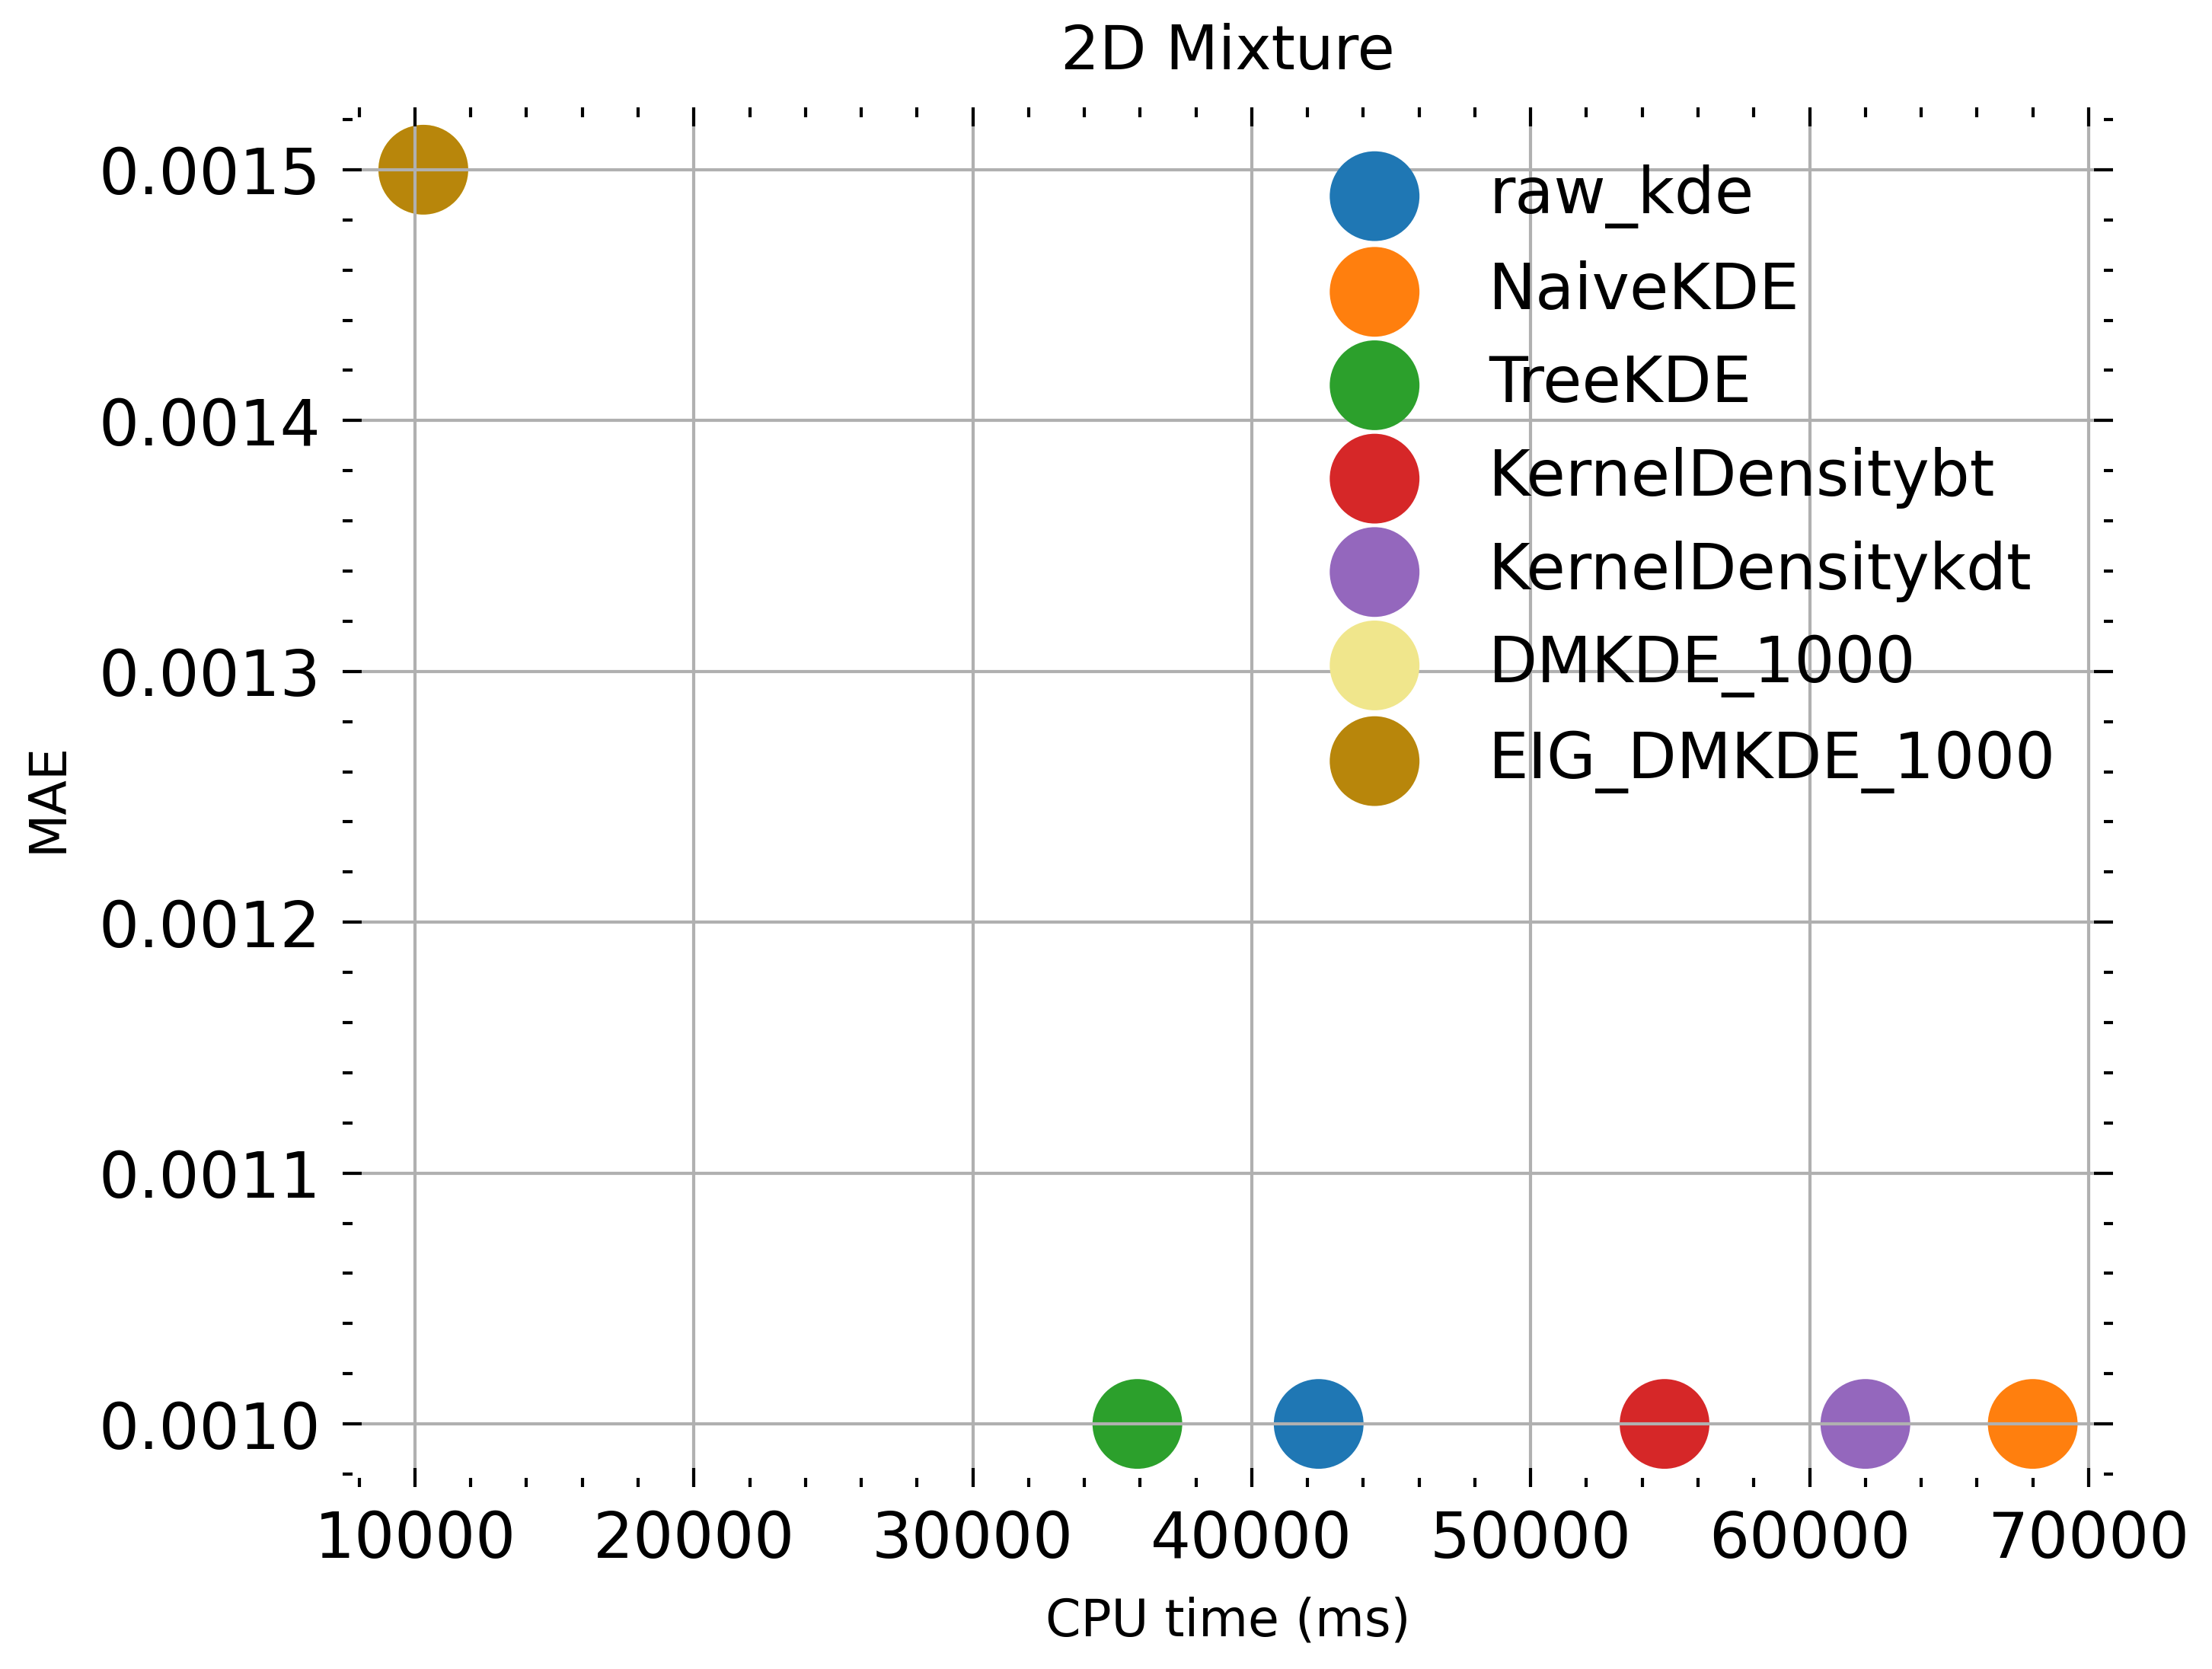

In [17]:
#raw_kde
CPU_time_raw_kde = [202,200,550,4000,42400][4]
#NaiveKDE
CPU_time_NaiveKDE = [11.9,70.2,707,6950,68000][4]
#TreeKDE
CPU_time_TreeKDE = [3590,3120,3630,6360,35900][4]
#KernelDensitybt
CPU_time_KernelDensitybt = [14.7,85.4,641,5110,54800][4]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [11.7,84.5,703,5000,62000][4]
#fastKDE
#CPU_time_fastKDE = [9030,14700,14700,29200,58700][4]
#DMKDE_50
CPU_time_DMKDE_50 = [675,691,656,631,656][4]
#DMKDE_100
CPU_time_DMKDE_100 = [1870,1630,1630,1560,1610][4]
#DMKDE_500
CPU_time_DMKDE_500 = [110000,91000,91000,91000,91000][4]
#DMKDE_1000
CPU_time_DMKDE_1000 = [713000,596000,603000,593000,603000][4]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [531,592,461,443,456][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [397,511,507,494,484][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [492,635,1660,3560,3500][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [663,920,2670,10200,10300][4]


#raw_kde
error_raw_kde = [0.0085,0.0048,0.0023,0.0012,0.0010][4]
#NaiveKDE
error_NaiveKDE = [0.0085,0.0048,0.0023,0.0012,0.0010][4]
#TreeKDE
error_TreeKDE = [0.0085,0.0048,0.0023,0.0012,0.0010][4]
#KernelDensitybt
error_KernelDensitybt = [0.0085,0.0048,0.0023,0.0012,0.0010][4]
#KernelDensitykdt
error_KernelDensitykdt = [0.0085,0.0048,0.0023,0.0012,0.0010][4]
#fastKDE
#error_fastKDE = [0.0123,0.0062,0.0018,0.0006,0.0002][4]
#DMKDE_50
error_DMKDE_50 = [0.0100,0.0099,0.0206,0.0208,0.0208][4]
#DMKDE_100
error_DMKDE_100 = [0.0097,0.0080,0.0123,0.0125,0.0125][4]
#DMKDE_500
error_DMKDE_500 = [0.0100,0.0061,0.0026,0.0016,0.0016][4]
#DMKDE_1000
error_DMKDE_1000 = [0.0102,0.0062,0.0026,0.0017,0.0015][4]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0100,0.0099,0.0206,0.0208,0.0208][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0097,0.0080,0.0123,0.0125,0.0125][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0100,0.0061,0.0026,0.0016,0.0016][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.0102,0.0063,0.0026,0.0017,0.0015][4]



scatter_100m ={"raw_kde": [CPU_time_raw_kde,error_raw_kde],
                'NaiveKDE':[CPU_time_NaiveKDE,error_NaiveKDE],
                'TreeKDE':[CPU_time_TreeKDE,error_TreeKDE],
                'KernelDensitybt':[CPU_time_KernelDensitybt,error_KernelDensitybt],
                'KernelDensitykdt':[CPU_time_KernelDensitykdt,error_KernelDensitykdt],
                'DMKDE_50':[CPU_time_DMKDE_50,error_DMKDE_50],
                'DMKDE_100':[CPU_time_DMKDE_100,error_DMKDE_100],
                'DMKDE_500':[CPU_time_DMKDE_500,error_DMKDE_500],
                'DMKDE_1000':[CPU_time_EIG_DMKDE_1000,error_DMKDE_1000],
                'EIG_DMKDE_50':[CPU_time_EIG_DMKDE_50,error_EIG_DMKDE_50],
                'EIG_DMKDE_100':[CPU_time_EIG_DMKDE_100,error_EIG_DMKDE_100],
                'EIG_DMKDE_500':[CPU_time_EIG_DMKDE_500,error_EIG_DMKDE_500],
                'EIG_DMKDE_1000':[CPU_time_EIG_DMKDE_1000,error_EIG_DMKDE_1000]
          }

labels = ['raw_kde','NaiveKDE','TreeKDE','KernelDensitybt','KernelDensitykdt','DMKDE_1000', 'EIG_DMKDE_1000']

colors = np.array(['tab:blue','tab:orange','tab:green','tab:red','tab:purple','khaki','darkgoldenrod'])#
fig, ax = plt.subplots()
for color,label in zip(colors,labels):
    x, y = (scatter_100m[label][0],scatter_100m[label][1])
    ax.grid(True)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.scatter(x, y, c= color, label= label,s = 200, edgecolors='none')
ax.set_xlabel('CPU time (ms)')
ax.set_ylabel('MAE')
ax.set_title('2D Mixture')
ax.grid(b=True)
ax.legend(loc = 1)
fig.savefig('eff_2Dmixt.svg')

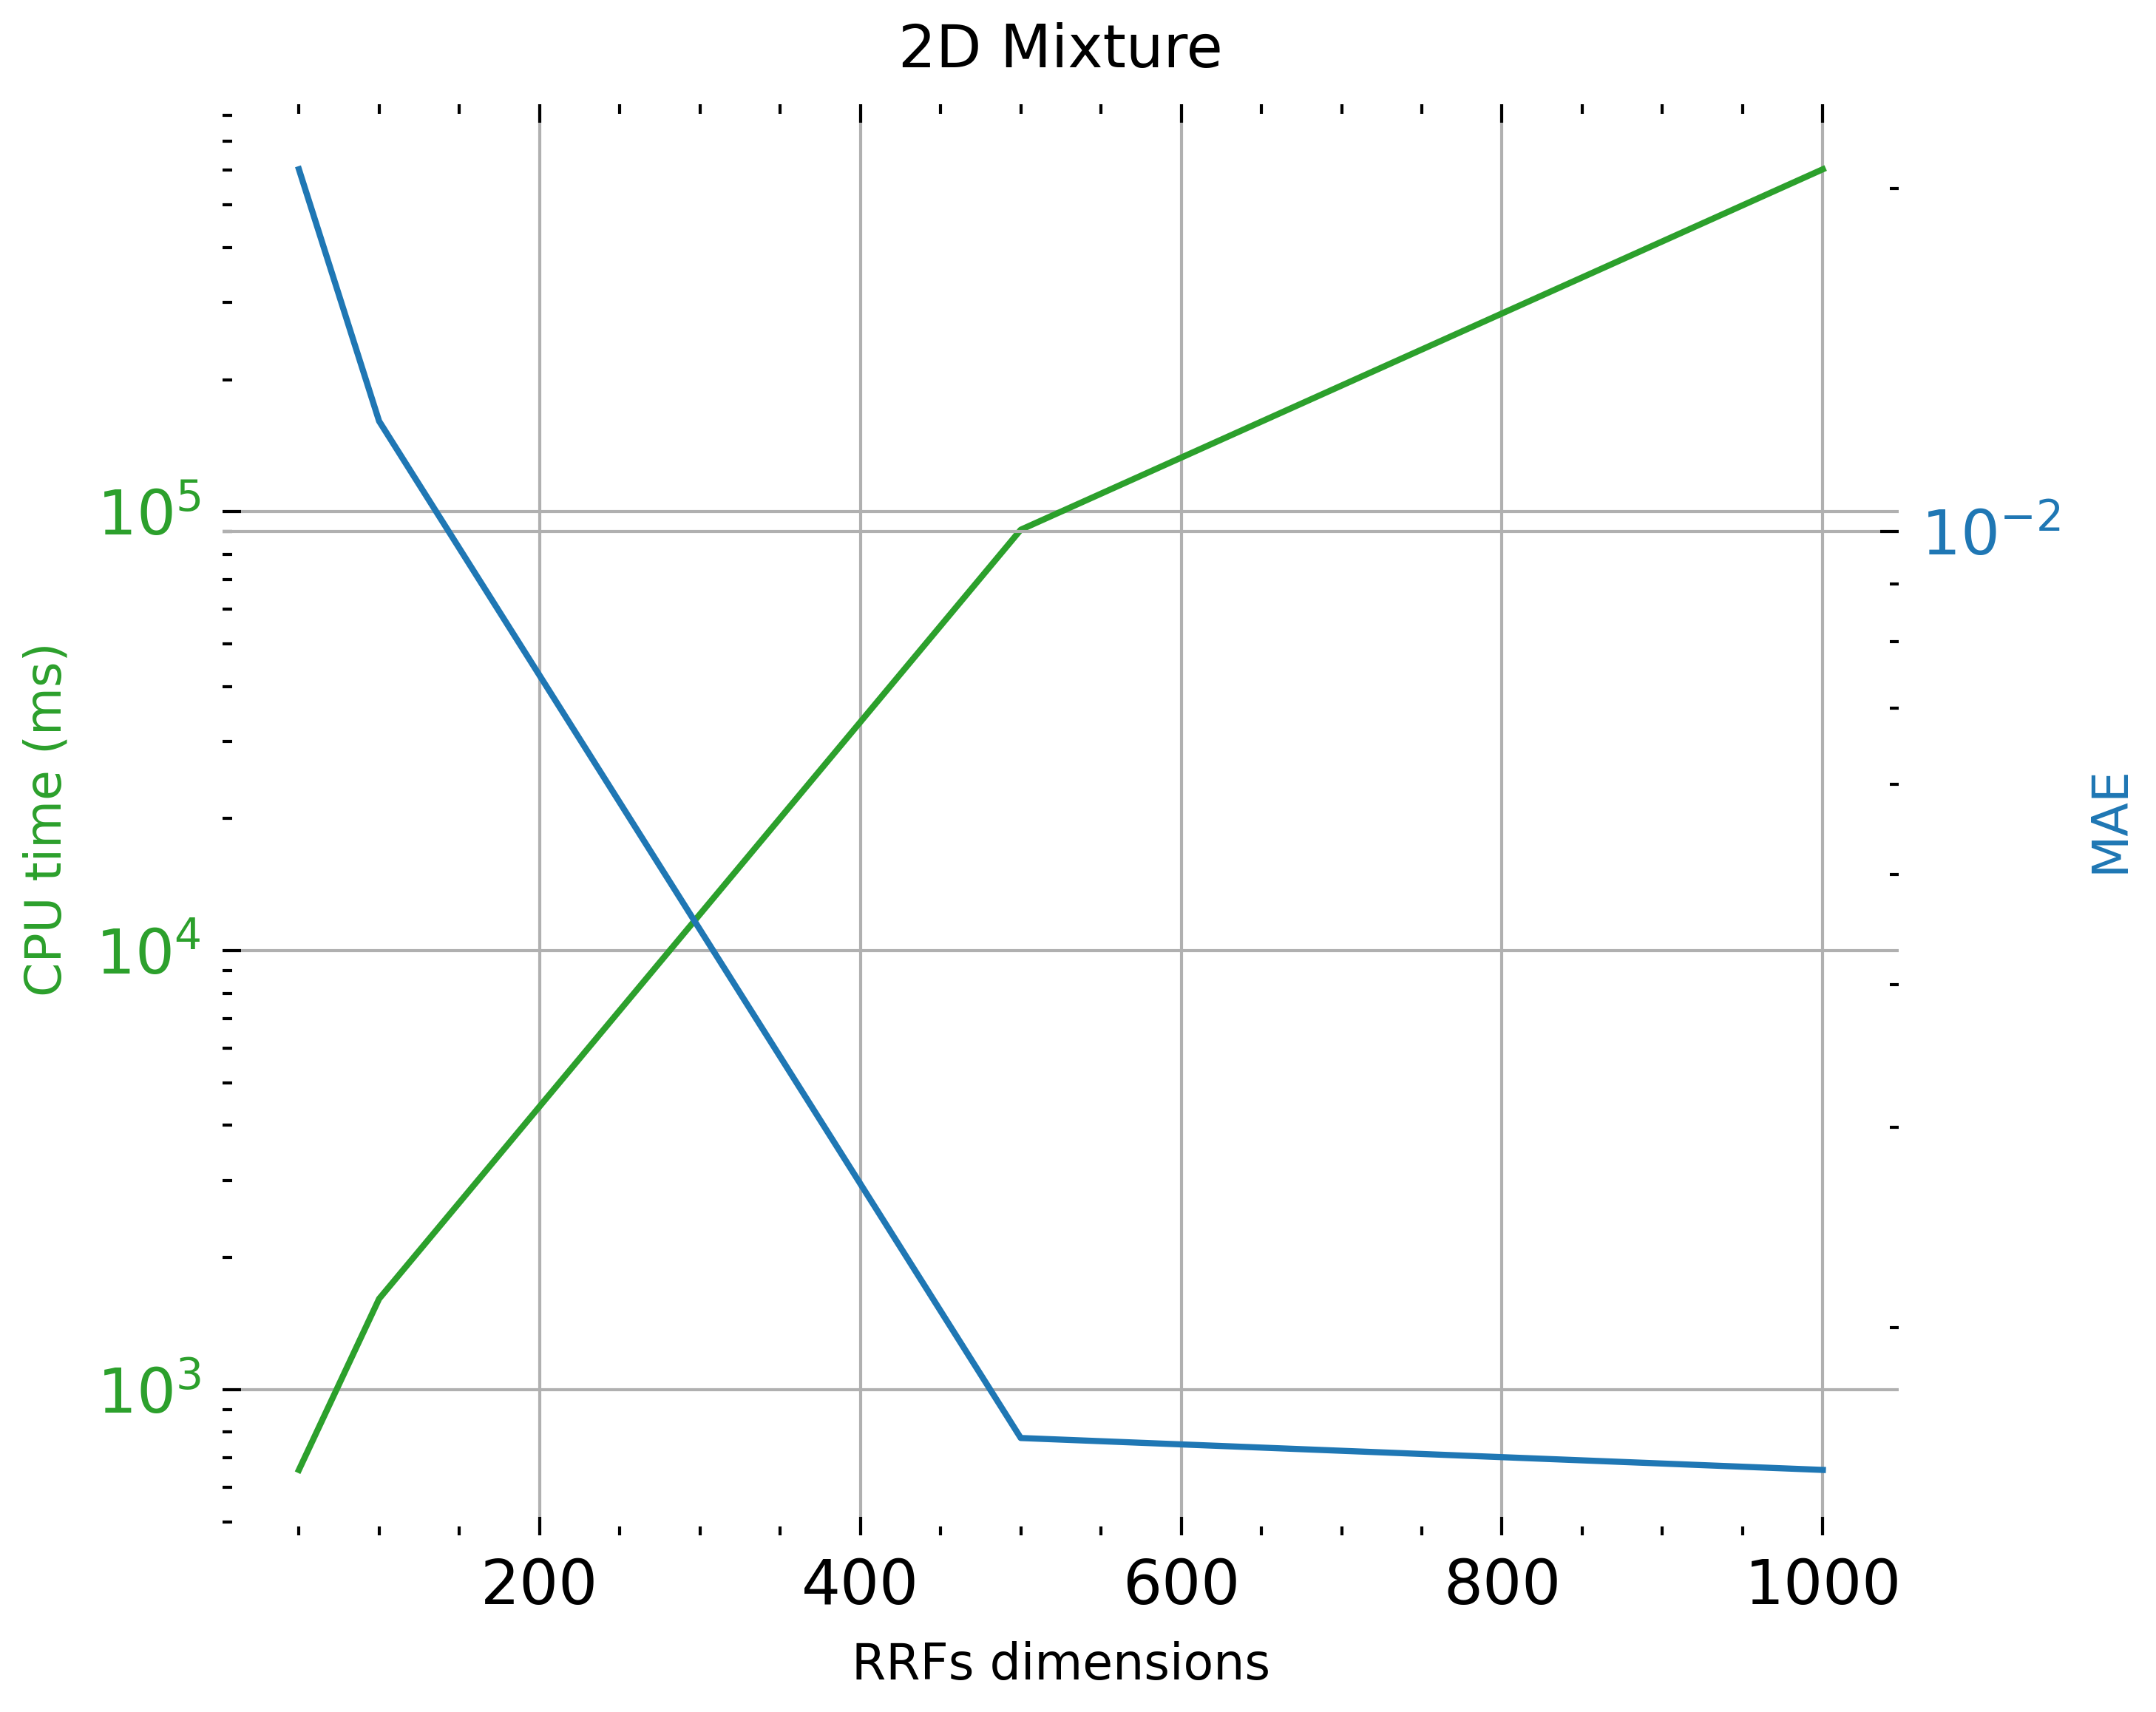

In [18]:
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [531,592,461,443,456][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [397,511,507,494,484][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [492,635,1660,3560,3500][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [663,920,2670,10200,10300][4]

#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0100,0.0099,0.0206,0.0208,0.0208][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0097,0.0080,0.0123,0.0125,0.0125][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0100,0.0061,0.0026,0.0016,0.0016][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.0102,0.0063,0.0026,0.0017,0.0015][4]
t = [50.,100.,500.,1000.]
data1 = [CPU_time_DMKDE_50,CPU_time_DMKDE_100,CPU_time_DMKDE_500,CPU_time_DMKDE_1000]
data2 = [error_EIG_DMKDE_50,error_EIG_DMKDE_100,error_EIG_DMKDE_500,error_EIG_DMKDE_1000]

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_title('2D Mixture')
ax1.grid(True)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.set_xlabel('RRFs dimensions')
ax1.set_ylabel('CPU time (ms)', color=color)
ax1.set_yscale('log')
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.grid(True)
ax2.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.set_ylabel('MAE', color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('rff_2Dmixt.png', dpi=300)
plt.show()